<font size="6"> KAGRA Main Interferometer Optical Layout</font>

# Introduction

This notebook constructs an optical layout for the bKAGRA main interferometer and the input optics.


## Requirements for running this notebook

### Modules

You need to have the following packages:

- numpy
- scipy
- matplotlib
- gtrace

All of them can be installed with `pip` such as
```
pip install gtrace
```

### JupyterLab

Since this notebook is quite long, I highly recommend you to install [toc-extension](https://github.com/jupyterlab/jupyterlab) of JupyterLab for improved navigation throughout the notebook. You can find this extension in the extension manager of JupyterLab by searching for "toc".

For this reason, I also recommend you to use JupyterLab instead of Jupyter Notebook.

## Basic strategy

In this notebook, locations and orientations of all the interferometer mirrors as well as the IMC and IMMT mirrors are determined. In addition, radius of curvature of the reclycling cavity mirrors are also determined.

These layout parameters will be derived from several external constraints:

- Length of the arm cavities
    - Determined by the length of the tunnel
- RoCs of the test mass mirrors
    - Determined by the arm cavity stability, beam spot size choice, parametric instability and so on.
- Directions of the arm cavities
    - Two arms are exactly orthogonal to each other
- Lengths of the recycling cavities
    - Determined by the RF sideband resonant conditions for error signal extraction
- Schnupp asymmetry
    - Determined by the signal extraction scheme
- Distance between PRM and PR3, PR2 and BS and so on
    - Determined by the size of the vacuum chambers
- One-way Gouy phase in PRC and SRC
    - Determined to avoid the resonance of higher order modes in those cavities
- Mirror sizes
    - Determined by available substrates, production capabilities of manufacturers and so on.
- Wedge angles
    - Most relevant ones are wedge of ITMs and BS. These angles are manually adjusted by some iterations. This process is not captured in this notebook. So some explanation is necessary.
    - The wedge anlges of ITMs and BS changes the separation of ghost beams generated by the AR reflections in those mirrors.
    - Since the beam size is large between PR3-BS-ITMs-SR3, we do not want to separate the ghost beams from the main beam in this area.
    - It is desirable to separate those beams after the beam size gets smaller around PR2 or SR2.
    - Wedge angles are adjusted to nicely separate ghost beams in this small beam area.


## Layout construction steps

The optical layout of the main interferometer is constructed with the following steps.

- Determine the optimal incident angle to ITMs from the AR side so that the transmitted beam from hr side will be normal to the HR surface. (section 3.4)
- Determine the optimal BS orientation and the incident angle so that the two beams leaving the BS are exactly orthogonal to each other. (section 3.5)
- Put PRM, PR2, PR3, BS and ITMs in this order by actually propagating a test beam along this beam path. (section 3.6.1 to 3.6.3)
- Make small adjustments to ITM positions based on the beam propagation result to center the beam spot on the ITMs and also set Lprc to the design value taking into account the optical distance of substrate transmission. (section 3.6.4 and 3.6.5)
- Put ETMs (section 3.6.6)
- By propagating beams coming back from ITMs, construct the SRC part (section 3.6.7)
    - SRCX and SRCY are exactly identical
- Check the parameters of the constructed PRC by propagating a beam through it. (section 3.7)
- Create an instance of Cavity class for arm cavities to find their eigen modes. (section 3.8)
    - These eigen modes are used to measure the Gouy phase shift in the recycling cavities in the following sections.
- Optimize the RoCs of the folding mirrors (section 3.9)
    - We want to find a combination of the RoCs for PR2 and PR3 which satisfy the following conditions:
        - One-way Gouy phase shift needs to be the designed value
        - Beam spot sizes on PRM and PR2 are the same
    - The final optimization is done in section 3.9.1.3 but we need to find a good starting point for optimization. It is found by doing scans of R2 and R3 in section 3.9.1.2.
    - Similar optimization is done for SRC (section 3.9.2)
- Construct the beam path again (section 3.10)
    - With the RoCs of the recycling mirrors updated, we perform the construction of the beam path again with the same procedure as before.
- Optimization of the RoCs of the recycling mirrors is done again with the updated beam path (section 3.12)
- The constructed optical layout is drawn into a DXF file. (section 3.18)


## About gtrace

gtrace is a Gaussian beam ray-tracing package for Python.

The package is hosted on GitHub: https://github.com/asoy01/gtrace

You can find some documentation in the `Manuals` directory above. Especially, `Tutorials` directory contains a Jupyter notebook to demonstrate the usage of gtrace.

You can also find an incomplete document of gtrace in Read The Docs (https://gtrace.readthedocs.io/). Here you can find a detailed API reference, which is automatically generated from doc strings.


## Viewing DXF files

The main output of gtrace is the drawing of an optical layout (mirrors and beams) in the DXF format. It is a 2D CAD format. Therefore, importing the optical layout information into other CAD software is easy.

For viewing a DXF file, any CAD software should be fine. If you do not have a CAD software, there are several free viewers. The easiest one will be the online viewer provided by Autodesk:
https://viewer.autodesk.com/

You can also install a desktop application called [DWG TrueView](https://www.autodesk.com/products/dwg).

[VariCAD Viewer](https://www.varicad.com/en/home/products/products/) is also a good choice for viewing DXF files. The author of gtrace uses VariCAD.

Depending on viewer software, you may need to swtich the background color to "black" to properly see the shape of mirrors and chambers.

# Preparation

## Import modules

In [282]:
#Standard modules
import sys
import os
import copy
import time
import _pickle
from pprint import pprint

#Plot library
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties, FontManager

#Numpy related
import numpy as np
pi = np.pi

#Scipy related
import scipy as sp
import scipy.special as spf
import scipy.optimize as sopt
from scipy.constants import c

#gtrace related
import gtrace.beam as beam
import gtrace.optcomp as opt
from gtrace.nonsequential import non_seq_trace
from gtrace.draw.tools import drawAllBeams, drawAllOptics, transAll, rotateAll, drawOptSys
import gtrace.draw as draw
import gtrace.draw.renderer as renderer
from gtrace.unit import *
import gtrace.optics.gaussian as gauss
from gtrace.optics.cavity import Cavity
import gtrace.optics.geometric as geom


## Load utility functions

In [240]:
%run ./Utility_functions.ipynb

## Load parameters

In [241]:
%run ./Parameters.ipynb

## Define mirrors

In [242]:
%run ./Mirrors.ipynb

# Construct the bKAGRA optical layout

## Parameters

In [243]:
# Target values of one-way Gouy phase in PRC and SRC in degrees.
targetGouyPRC = 16.5
targetGouySRC = 17.5

# Starting point of the recycling mirror ROCs for optimization. They are not the final values.
PR2_ROC = -3.08
PR3_ROC = 24.9
SR2_ROC = -2.977
SR3_ROC = 24.785


## Set the recycling mirror ROCs to temporaly values

In [244]:

PR2.inv_ROC_HR = 1/PR2_ROC
PR3.inv_ROC_HR = 1/PR3_ROC

SR2.inv_ROC_HR = 1/SR2_ROC
SR3.inv_ROC_HR = 1/SR3_ROC


## Output file names

File names for saving the final results.

In [245]:
log_file_name = 'Layout/bKAGRA_log.txt'
dxf_file_name = 'Layout/bKAGRA.dxf'

## Calculate the optimal ITM incident angle

Since the ITMs have wedge, the incident angle of the beam from the back of ITMs should be adjusted so that beam leaving from the HR side will be normal to the HR surface.

theta_ITMX is the angle (measured from X-axis) of the beam hitting ITMX from the AR side.

theta_ITMY is the angle (measured from Y-axis) of the beam hitting ITMY from the AR side.

In [246]:
theta_w = ITMX.wedgeAngle
n = ITMX.n

theta_ITMX = np.arcsin(n*np.sin(theta_w))-theta_w

theta_w = ITMY.wedgeAngle
n = ITMY.n

theta_ITMY = np.arcsin(n*np.sin(theta_w))-theta_w


## Calculate the optimal incident angle for BS

Considering that the BS also has wedge, we need to adjust the incident angle and the orientation of the BS so that the two beams going to X and Y directions have correct angles of incidence on ITMs.

Here, we will find the answer (optimal incident angle for BS) by an optimization process using the Newton-Lapson method.

theta_BS is the angle of the normal vector of the BS HR measured from X-axis.

theta_in_BS is the angle (measured from X-axis) of the beam hitting the BS from the PR3 side.

In [247]:
theta_w = BS.wedgeAngle
n = BS.n

def testfun(theta_BS):
    a1 = theta_BS - pi/2 + theta_ITMY
    a2 = np.arcsin(np.sin(a1)/n)
    a3 = a2 - theta_w
    a4 = np.arcsin(n*np.sin(a3))
    a5 = a4+theta_w
    return theta_ITMX - pi + a5 +theta_BS

ans = sopt.newton(testfun, pi/2+pi/4)

theta_BS = ans
theta_in_BS = -(3*pi/2 - 2*theta_BS - theta_ITMY)

#BS optical thickness
a1 = theta_BS - pi/2 + theta_ITMY
a2 = np.arcsin(np.sin(a1)/n)
dBS = BS.n*BS.thickness/np.cos(a2)


## Put mirrors

Now, we will put mirrors one by one.

### Prepare a source beam

Prepare a test beam to be propagated in the optical path. The beam parameters are arbitrary, because we do not care about the Gaussian beam evolution at this stage.

In [248]:
q = gauss.Rw2q(ROC=-1/PRM.inv_ROC_HR, w=4*mm)
srcBeam = beam.GaussianBeam(q0=q, pos=[0,0], dirAngle=0.0)
srcBeam.optDist = 0.0


### Put mirrors from PRM to BS

By propagating a test beam from PRM, we construct

In [249]:
#Position the PRM at [0,0]
PRM.HRcenter = [0,0]

#Orient the PRM based on the incident angle to BS and the folding angles.
PRM.normAngleHR = theta_in_BS + 2*(foldingAngle2 - foldingAngle1)
srcBeam.dirAngle = theta_in_BS + 2*(foldingAngle2 - foldingAngle1)

#Put PR2
PR2.normAngleHR = pi+PRM.normAngleHR
PR2.rotate(foldingAngle1)
PR2.HRcenter = PRM.HRcenter + PRM.normVectHR*L_PRM_PR2

#Hit PR2
beams = PR2.hitFromHR(srcBeam, order=1)
beamToPR3 = beams['r1']

#Put PR3
PR3.HRcenter = PR2.HRcenter + L_PR2_PR3*beamToPR3.dirVect
PR3.normVectHR = - beamToPR3.dirVect
PR3.rotate(-foldingAngle2)

#Hit PR3
beams = PR3.hitFromHR(beamToPR3)
beamToBS = beams['r1']

#Put BS
BS.HRcenter = PR3.HRcenter + L_PR3_BS*beamToBS.dirVect
BS.normAngleHR = theta_BS


### Roughly locate ITMs

In [250]:
#Hit BS
beams = BS.hitFromHR(beamToBS)
beamToITMY = beams['r1']
beamToITMX = beams['t1']

#Orient ITMX and ITMY
ITMX.normAngleHR = 0.0
ITMY.normAngleHR = deg2rad(90.0)

#ITM optical thickness
dITM = ITMX.thickness*ITMX.n

#Put ITMX
ITMX.HRcenter = (L_BS_ITMX - dBS - (dITM - ITMX.thickness))*beamToITMX.dirVect + beamToITMX.pos

#Put ITMY
ITMY.HRcenter = (L_BS_ITMY - (dITM - ITMY.thickness))*beamToITMY.dirVect + beamToITMY.pos


### Center the beams on the ITMs

In [251]:
#Hit ITMX
beams = ITMX.hitFromAR(beamToITMX)
beamITMXt1 = beams['t1']

#Hit ITMY
beams = ITMY.hitFromAR(beamToITMY)
beamITMYt1 = beams['t1']

#Move ITMs to center the beams
v1= beamITMXt1.pos - ITMX.HRcenter
ITMX.translate(v1)

v1= beamITMYt1.pos - ITMY.HRcenter
ITMY.translate(v1)


### Adjust the Lprc and Las by moving ITMs

ITMs are moved to make Lprc and Las have the designed values.

We use the optical distance accumurated by the test beam propagated through PRC to know the exact values of Lprc and Las.

In [252]:
#Hit ITMX again
beams = ITMX.hitFromAR(beamToITMX)
beamITMXt1 = beams['t1']

#Move the ITMX to make the length correct
dx = Lprc + Las/2 - beamITMXt1.optDist
ITMX.translate(dx*beamToITMX.dirVect)

#Hit ITMY again
beams = ITMY.hitFromAR(beamToITMY)
beamITMYt1 = beams['t1']

#Move the ITMY to make the length correct
dy = Lprc - Las/2 - beamITMYt1.optDist
ITMY.translate(dy*beamToITMY.dirVect)


### Put ETMs

In [253]:
#Hit ITMX again
beams = ITMX.hitFromAR(beamToITMX)
beamITMXt1 = beams['t1']

ETMX.HRcenter = beamITMXt1.pos + beamITMXt1.dirVect*Larm
ETMX.normVectHR = - beamITMXt1.dirVect

#Hit ITMY again
beams = ITMY.hitFromAR(beamToITMY)
beamITMYt1 = beams['t1']

ETMY.HRcenter = beamITMYt1.pos + beamITMYt1.dirVect*Larm
ETMY.normVectHR = - beamITMYt1.dirVect


### Construct SRC

#### SRCX

Construct the SRC using the beam coming back from ITMX

In [265]:
#Hit ITMX again
beams = ITMX.hitFromAR(beamToITMX, order=1)
beamITMXt1 = beams['t1']
beamITMXr2 = beams['r2']
beamITMXr2.optDist = beamITMXr2.optDist - beams['s2'].optDist

#Hit BS
beams = BS.hitFromAR(beamITMXr2, order=1)
beamBStoSR3X = beams['r2']

#Put SR3
d = L_SR3_BS - (beamBStoSR3X.optDist - L_BS_ITMX)
SR3.HRcenter = beamBStoSR3X.pos + d*beamBStoSR3X.dirVect
SR3.normVectHR = - beamBStoSR3X.dirVect
SR3.rotate(-foldingAngle2)

#Hit SR3
beams = SR3.hitFromHR(beamBStoSR3X)
beamSR3toSR2X = beams['r1']

#Put SR2
SR2.HRcenter = beamSR3toSR2X.pos + L_SR2_SR3*beamSR3toSR2X.dirVect
SR2.normVectHR = - beamSR3toSR2X.dirVect
SR2.rotate(foldingAngle1)

#Hit SR2
beams = SR2.hitFromHR(beamSR3toSR2X)
beamSR2toSRMX = beams['r1']

#Put SRM
SRM.HRcenter = beamSR2toSRMX.pos + L_SRM_SR2*beamSR2toSRMX.dirVect
SRM.normVectHR = - beamSR2toSRMX.dirVect

#Hit SRM
beams = SRM.hitFromHR(beamSR2toSRMX)
beamSRMs1X = beams['s1']


#### SRCY

Construct SRC using the beam reflected back from ITMY

In [269]:
#Hit ITMY again
beams = ITMY.hitFromAR(beamToITMY, order=2)
beamITMYt1 = beams['t1']
beamITMYr2 = beams['r2']
beamITMYr2.optDist = beamITMYr2.optDist - beams['s2'].optDist

#Hit BS
beams = BS.hitFromHR(beamITMYr2, order=1)
beamBStoSR3Y = beams['t1']

#Put SR3
d = L_SR3_BS - (beamBStoSR3Y.optDist - L_BS_ITMY)
SR3.HRcenter = beamBStoSR3Y.pos + d*beamBStoSR3Y.dirVect
SR3.normVectHR = - beamBStoSR3Y.dirVect
SR3.rotate(-foldingAngle2)

#Hit SR3
beams = SR3.hitFromHR(beamBStoSR3Y)
beamSR3toSR2Y = beams['r1']

#Put SR2
SR2.HRcenter = beamSR3toSR2Y.pos + L_SR2_SR3*beamSR3toSR2Y.dirVect
SR2.normVectHR = - beamSR3toSR2Y.dirVect
SR2.rotate(foldingAngle1)

#Hit SR2
beams = SR2.hitFromHR(beamSR3toSR2Y)
beamSR2toSRMY = beams['r1']

#Put SRM
SRM.HRcenter = beamSR2toSRMY.pos + L_SRM_SR2*beamSR2toSRMY.dirVect
SRM.normVectHR = - beamSR2toSRMY.dirVect

#Hit SRM
beams = SRM.hitFromHR(beamSR2toSRMY)
beamSRMs1Y = beams['s1']


## Check the layout of the PRC part

In [281]:
(results, beamDict, auxBeamDict) = propagateOpticalPathFromPRM(q)
pprint(results)

{'BSIncAngle': 0.7848462359779871,
 'ITMXangle': 359.9999999999999,
 'ITMXbeamCentering': -7.084194342255046e-12,
 'ITMYangle': 90.0,
 'ITMYbeamCentering': 7.084111075528199e-12,
 'LPRCX': 68.25625341213855,
 'LPRCY': 64.92640256457136,
 'LPRCavg': 66.59132798835495,
 'Lasym': 3.3298508475671866}


## Arm Cavities

Calculate the parameters of the arm cavities and prepare eigenmode beams for them.

In [150]:
ArmCavity = Cavity(r1=ITMX.Refl_HR, r2=ETMX.Refl_HR, L=Larm, R1=-ITM_ROC, R2=ETM_ROC*1, power=True)

(q0arm, d) = ArmCavity.waist()

beamArmWaistX = beam.GaussianBeam(q0=q0arm)
beamArmWaistX.pos = ITMX.HRcenter + ITMX.normVectHR*d
beamArmWaistX.dirVect = - ITMX.normVectHR

beamArmWaistY = beam.GaussianBeam(q0=q0arm)
beamArmWaistY.pos = ITMY.HRcenter + ITMY.normVectHR*d
beamArmWaistY.dirVect = - ITMY.normVectHR

#Arm cavity one-way Gouy phase shift
ArmGouyPhase = np.arctan((Larm-d)/np.imag(q0arm)) - np.arctan(-d/np.imag(q0arm))


## Optimize the RoCs of the folding mirrors

RoCs of the recycling cavity mirrors are optimized to achieve the desired values of one-way Guoy phase shift.

In addition to the Gouy phase, we also aim to have equal beam spot sizes on PR2 and PRM (also SR2 and SRM) because this will give a reasonably collimated beam there.

### PRC

#### Optimization functions

In [151]:
#A Function to compute the one way Gouy phase shift of PRC and return the difference from the target value, given the RoCs of PR2 and PR3.
def testFunc1(R2,R3,target=20.0):
    PR3.inv_ROC_HR = 1.0/R3
    PR2.inv_ROC_HR = 1.0/R2
    (result, beamDictX, beamDictY) = \
             propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
    return rad2deg(result['AvgGouyPRCX'] + result['AvgGouyPRCY'])/2 -target

#A function used to optimize R3 to make the beam spot size equal on PR2 and PRM
#Given R3, this function computes an optimal PR2 ROC to realize the desired one-way Gouy phase.
#Then it will return the difference of the beam spot size on PRM and PR2.
def testFunc2(R3):
    optR2 = sopt.newton(testFunc1, PR2_ROC, args=(R3, targetGouyPRC))
    (result, beamDictX, beamDictY) = \
             propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
    return (result['PR2 Spot Size'] - result['PRM Spot Size'])*1000.0


#### Find the starting point of optimization

Scan PR2_ROC and PR3_ROC to see where the one-way Gouy phase is near the design value and also when the beam spot sizes on PR2 and PRM becomes similar.

This scan result is used to find starting points for the final optimization of the ROCs.


First, we fix the value of R3, scan R2 to see the Gouy Phase

In [152]:
residue = 10.0

while residue > 8./(1+(deg2rad(targetGouyPRC)-pi/2)**2):
    N = 100
    R2s = np.linspace(-1.5,1.5, N)+PR2_ROC
    print('Scanning %f < R2 < %f with R3 = %f'%(np.min(R2s), np.max(R2s), PR3_ROC))

    PR3.inv_ROC_HR = 1.0/PR3_ROC
    GouyArray = np.empty(N)
    SpotArray1 = np.empty(N)
    SpotArray2 = np.empty(N)

    for ii in range(N):
        PR2.inv_ROC_HR = 1.0/R2s[ii]
        (result, beamDictX, beamDictY) = \
                 propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
        GouyArray[ii] = rad2deg(result['AvgGouyPRCX'] + result['AvgGouyPRCY'])/2
        SpotArray1[ii] = result['PR2 Spot Size']*1000
        SpotArray2[ii] = result['PRM Spot Size']    *1000


    minIdx = np.argmin(np.abs(GouyArray - targetGouyPRC))
    residue = np.abs(GouyArray[minIdx] - targetGouyPRC)
    print('Residue = %f'%residue)

    #Start Point
    PR2_ROC = R2s[minIdx]


Scanning -4.580000 < R2 < -1.580000 with R3 = 24.900000
Residue = 0.393703


Plot the scanning result

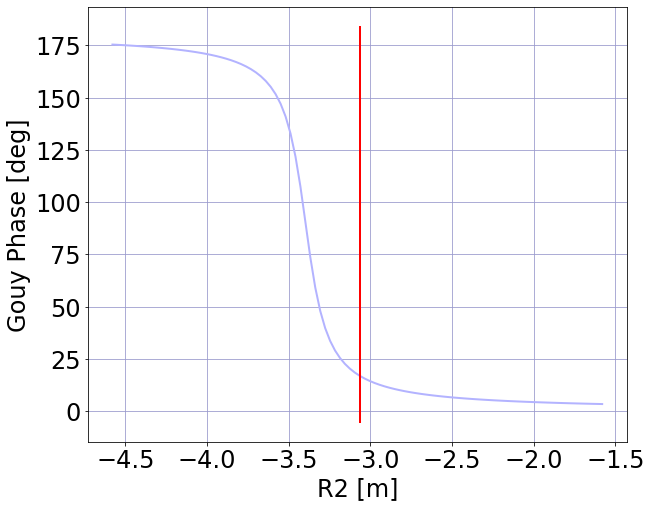

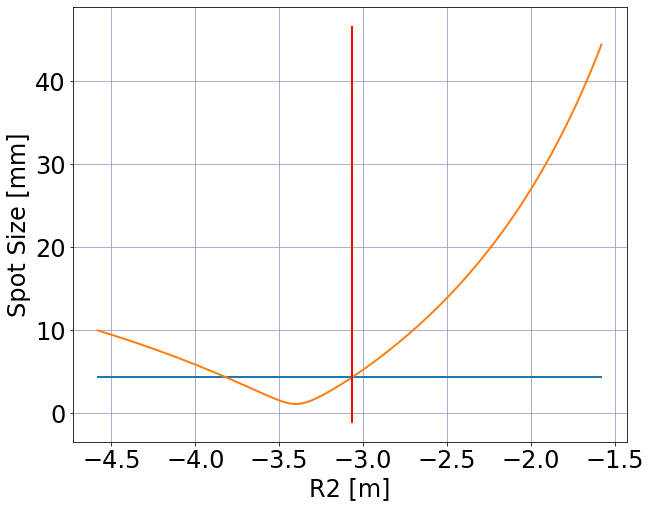

In [153]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(R2s, GouyArray, lw=2, color=(0.7,0.7,1))
(ymin, ymax) = ax.get_ylim()
ax.plot([PR2_ROC, PR2_ROC], [ymin, ymax], lw=2, color='red')        

ax.grid(True, color=(0.6,0.6,0.8),ls='-')
ax.grid(True, which='minor',color=(0.6,0.6,0.6),ls='--')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(24)
ax.set_xlabel('R2 [m]', size=24)
ax.set_ylabel('Gouy Phase [deg]', size=24)
ax.figure.set_size_inches(9,7, forward=True)
plt.tight_layout(pad=0.5)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(R2s, SpotArray1, lw=2)
ax.plot(R2s, SpotArray2, lw=2)
(ymin, ymax) = ax.get_ylim()
ax.plot([PR2_ROC, PR2_ROC], [ymin, ymax], lw=2, color='red')

ax.grid(True, color=(0.6,0.6,0.8),ls='-')
ax.grid(True, which='minor',color=(0.6,0.6,0.6),ls='--')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(24)
ax.set_xlabel('R2 [m]', size=24)
ax.set_ylabel('Spot Size [mm]', size=24)
ax.figure.set_size_inches(9,7, forward=True)
plt.tight_layout(pad=0.5)


Next, we scan R3 and optimize R2 at each point

In [154]:
residue = 1.0
N = 25
dR3 = 0.02

#Prepare arrays
GouyArray = np.empty(2*N, dtype='float64')
SpotArray1 = np.empty(2*N, dtype='float64')
SpotArray2 = np.empty(2*N, dtype='float64')
R2Array = np.empty(2*N, dtype='float64')    
R3Array = np.empty(2*N, dtype='float64')    

while residue > 0.1:
    tic = time.time()
    print('Scanning R3 around %f'%(PR3_ROC))

    R3 = PR3_ROC - dR3*N
    R2 = PR2_ROC

    for ii in range(2*N):
        R2 = sopt.newton(testFunc1, R2, args=(R3, targetGouyPRC))
        PR2.inv_ROC_HR = 1.0/R2
        PR3.inv_ROC_HR = 1.0/R3
        (result, beamDictX, beamDictY) = \
                 propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)

        GouyArray[ii] = rad2deg(result['AvgGouyPRCX'] + result['AvgGouyPRCY'])/2
        SpotArray1[ii] = result['PR2 Spot Size']*1000
        SpotArray2[ii] = result['PRM Spot Size']*1000
        R2Array[ii] = R2
        R3Array[ii] = R3

        R3 = R3 + dR3

    minIdx = np.argmin(np.abs(SpotArray1 - SpotArray2))
    residue = np.abs(SpotArray1[minIdx] - SpotArray2[minIdx])

    print('Residue = %f'%residue)
    toc = time.time()
    print('Elapsed time = %f'%(toc - tic))

#Set the start point of optimization
PR2_ROC = R2Array[minIdx]
PR3_ROC = R3Array[minIdx]



Scanning R3 around 24.900000
Residue = 0.009581
Elapsed time = 17.940633


Plot

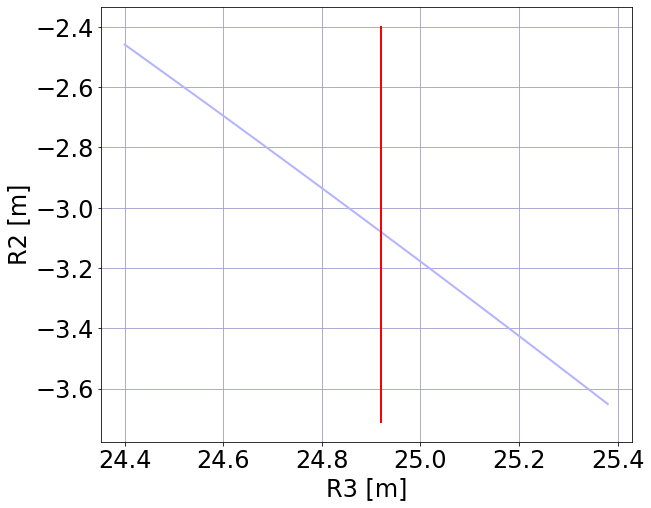

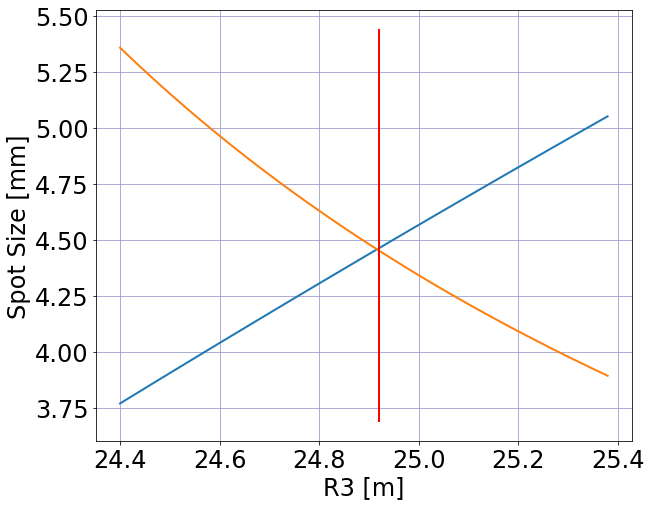

In [155]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(R3Array, R2Array, lw=2, color=(0.7,0.7,1))
(ymin, ymax) = ax.get_ylim()
ax.plot([PR3_ROC, PR3_ROC], [ymin, ymax], lw=2, color='red')

ax.grid(True, color=(0.6,0.6,0.8),ls='-')
ax.grid(True, which='minor',color=(0.6,0.6,0.6),ls='--')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(24)
ax.set_xlabel('R3 [m]', size=24)
ax.set_ylabel('R2 [m]', size=24)
ax.figure.set_size_inches(9,7, forward=True)
plt.tight_layout(pad=0.5)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(R3Array, SpotArray1, lw=2)
ax.plot(R3Array, SpotArray2, lw=2)
(ymin, ymax) = ax.get_ylim()
ax.plot([PR3_ROC, PR3_ROC], [ymin, ymax], lw=2, color='red')

ax.grid(True, color=(0.6,0.6,0.8),ls='-')
ax.grid(True, which='minor',color=(0.6,0.6,0.6),ls='--')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(24)
ax.set_xlabel('R3 [m]', size=24)
ax.set_ylabel('Spot Size [mm]', size=24)
ax.figure.set_size_inches(9,7, forward=True)
plt.tight_layout(pad=0.5)


#### Final Optimization

In [156]:
#Optimal R3
optR3 = sopt.newton(testFunc2, PR3_ROC)
PR3_ROC = optR3
PR3.inv_ROC_HR = 1.0/optR3

#Optimal R2
optR2 = sopt.newton(testFunc1, PR2_ROC, args=(optR3, targetGouyPRC))
PR2.inv_ROC_HR = 1.0/optR2
PR2_ROC = optR2

#Optimal PRM ROC
(result, beamDictX, beamDictY) = \
         propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
PRM_ROC = result['PRM ROC']
PRM.inv_ROC_HR = 1.0/PRM_ROC


### SRC

We want to make the ROCs of SRs similar to PRs for ease of fabrication.

Therefore, we do not make an optimization by changing the ROCs. Instead, we adjust the distance between SR2 and SR3 to achieve the design value of the Gouy phase.

#### Save the current positions of the SRC mirrors

In [157]:
SRM_Position0 = SRM.HRcenter
SR2_Position0 = SR2.HRcenter
SR3_Position0 = SR3.HRcenter

SRM_Orientation0 = SRM.normVectHR
SR2_Orientation0 = SR2.normVectHR
SR3_Orientation0 = SR3.normVectHR

(result, beamDictX, beamDictY) = \
         propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
inc_vect_SR3 = beamDictX['beamBStoSR3'].dirVect


#### Start point for optimization

The extra 9.4cm in SR2_ROC is a hand-picked magic number to make the beam spot sizes similar on SR2 and SRM.

In [158]:
SR2_ROC = PR2_ROC+9.4*cm
SR3_ROC = PR3_ROC

SR2.inv_ROC_HR = 1/SR2_ROC
SR3.inv_ROC_HR = 1/SR3_ROC


#### Optimization by Ls2

In [159]:
#A function to return the difference of the Gouy phase from the target value,
#given the change of Ls2

def testFunc1(dLs2):
    SRM.HRcenter = SRM_Position0
    SR2.HRcenter = SR2_Position0
    SR3.HRcenter = SR3_Position0
    SRM.normVectHR = SRM_Orientation0
    SR2.normVectHR = SR2_Orientation0
    SR3.normVectHR = SR3_Orientation0

    changeLs2(dLs2/2, dLs2/2, inc_vect_SR3=inc_vect_SR3)
    (result, beamDictX, beamDictY) = \
             propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)

    GouySRC = rad2deg((result['AvgGouySRCX']+result['AvgGouySRCY'])/2)
    residualGouy = GouySRC - targetGouySRC
    return residualGouy

#A function to return the difference between the ROC of PRM and SRM
#given the change of the SR2_ROC
def testFunc2(dSR2_ROC):
    SR2_ROC = PR2_ROC+dSR2_ROC
    SR2.inv_ROC_HR = 1/SR2_ROC

    optdLs2= sopt.newton(testFunc1, 3*cm)
    
    (result, beamDictX, beamDictY) = \
             propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
    

    return result['SRM ROC'] - PRM_ROC

#Calculate the optimal SR2_ROC
dSR2= sopt.newton(testFunc2, 9*cm)
SR2_ROC = PR2_ROC+dSR2
SR2.inv_ROC_HR = 1/SR2_ROC

print('dSR2 = %fcm'%(dSR2/cm))

dLs2= sopt.newton(testFunc1, 3*cm)

print('dLs2 = %fcm'%(dLs2/cm))

(result, beamDictX, beamDictY) = \
         propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
GouySRC = rad2deg((result['AvgGouySRCX']+result['AvgGouySRCY'])/2)
SRM_ROC = result['SRM ROC']
SRM.inv_ROC_HR = 1.0/SRM_ROC

print('SRC Gouy Phase = %f deg'%GouySRC)
print('SRM ROC = %f m'%SRM_ROC)
print('PRM ROC = %f m'%PRM_ROC)


dSR2 = 9.409682cm
dLs2 = 4.789688cm
SRC Gouy Phase = 17.500001 deg
SRM ROC = 458.128515 m
PRM ROC = 458.128515 m


## Put mirrors again

With the optimizations of RoCs performed above, we will construct the optical path again.

### Prepare source beam

In [160]:
q = gauss.Rw2q(ROC=-1/PRM.inv_ROC_HR, w=4*mm)
srcBeam = beam.GaussianBeam(q0=q, pos=[0,0], dirAngle=0.0)
srcBeam.optDist = 0.0


### Construct a beam path from PRM to BS

In [161]:
#Position the PRM at [0,0]
PRM.HRcenter = [0,0]
#Rotate the PRM
PRM.normAngleHR = theta_in_BS + 2*(foldingAngle2 - foldingAngle1)
srcBeam.dirAngle = theta_in_BS + 2*(foldingAngle2 - foldingAngle1)

#Put PR2
PR2.normAngleHR = pi+PRM.normAngleHR
PR2.rotate(foldingAngle1)
PR2.HRcenter = PRM.HRcenter + PRM.normVectHR*L_PRM_PR2

#Hit PR2
beams = PR2.hitFromHR(srcBeam, order=1)
beamToPR3 = beams['r1']

#Put PR3
PR3.HRcenter = PR2.HRcenter + L_PR2_PR3*beamToPR3.dirVect
PR3.normVectHR = - beamToPR3.dirVect
PR3.rotate(-foldingAngle2)

#Hit PR3
beams = PR3.hitFromHR(beamToPR3)
beamToBS = beams['r1']

#Put BS
BS.HRcenter = PR3.HRcenter + L_PR3_BS*beamToBS.dirVect
BS.normAngleHR = theta_BS


### Roughly locate ITMs

In [162]:
#Hit BS
beams = BS.hitFromHR(beamToBS)
beamToITMY = beams['r1']
beamToITMX = beams['t1']

#Orient ITMX and ITMY
ITMX.normAngleHR = 0.0
ITMY.normAngleHR = deg2rad(90.0)

#ITM optical thickness
dITM = ITMX.thickness*ITMX.n

#Put ITMX
ITMX.HRcenter = (L_BS_ITMX - dBS - (dITM - ITMX.thickness))*beamToITMX.dirVect + beamToITMX.pos

#Put ITMY
ITMY.HRcenter = (L_BS_ITMY - (dITM - ITMY.thickness))*beamToITMY.dirVect + beamToITMY.pos


### Center the beams on the ITMs

In [163]:
#Hit ITMX
beams = ITMX.hitFromAR(beamToITMX)
beamITMXt1 = beams['t1']

#Hit ITMY
beams = ITMY.hitFromAR(beamToITMY)
beamITMYt1 = beams['t1']

#Move ITMs to center the beams
v1= beamITMXt1.pos - ITMX.HRcenter
ITMX.translate(v1)

v1= beamITMYt1.pos - ITMY.HRcenter
ITMY.translate(v1)



### Adjust the Lprc and Las by moving ITMs

In [164]:
#Hit ITMX again
beams = ITMX.hitFromAR(beamToITMX)
beamITMXt1 = beams['t1']

#Move the ITMX to make the length correct
dx = Lprc + Las/2 - beamITMXt1.optDist
ITMX.translate(dx*beamToITMX.dirVect)

#Hit ITMY again
beams = ITMY.hitFromAR(beamToITMY)
beamITMYt1 = beams['t1']

#Move the ITMY to make the length correct
dy = Lprc - Las/2 - beamITMYt1.optDist
ITMY.translate(dy*beamToITMY.dirVect)



### ETMs

In [165]:
#Hit ITMX again
beams = ITMX.hitFromAR(beamToITMX)
beamITMXt1 = beams['t1']

ETMX.HRcenter = beamITMXt1.pos + beamITMXt1.dirVect*Larm
ETMX.normVectHR = - beamITMXt1.dirVect

#Hit ITMY again
beams = ITMY.hitFromAR(beamToITMY)
beamITMYt1 = beams['t1']

ETMY.HRcenter = beamITMYt1.pos + beamITMYt1.dirVect*Larm
ETMY.normVectHR = - beamITMYt1.dirVect


### SRC

#### SRCX

In [166]:
#{{{ SRCX

#Hit ITMX again
beams = ITMX.hitFromAR(beamToITMX, order=1)
beamITMXt1 = beams['t1']
beamITMXr2 = beams['r2']
beamITMXr2.optDist = beamITMXr2.optDist - beams['s2'].optDist

#Hit BS
beams = BS.hitFromAR(beamITMXr2, order=1)
beamBStoSR3X = beams['r2']

#Put SR3
d = L_SR3_BS - (beamBStoSR3X.optDist - L_BS_ITMX) - dLs2/2
SR3.HRcenter = beamBStoSR3X.pos + d*beamBStoSR3X.dirVect
SR3.normVectHR = - beamBStoSR3X.dirVect
SR3.rotate(-foldingAngle2)

#Hit SR3
beams = SR3.hitFromHR(beamBStoSR3X)
beamSR3toSR2X = beams['r1']

#Put SR2
SR2.HRcenter = beamSR3toSR2X.pos + (L_SR2_SR3+dLs2)*beamSR3toSR2X.dirVect
SR2.normVectHR = - beamSR3toSR2X.dirVect
SR2.rotate(foldingAngle1)

#Hit SR2
beams = SR2.hitFromHR(beamSR3toSR2X)
beamSR2toSRMX = beams['r1']

#Put SRM
SRM.HRcenter = beamSR2toSRMX.pos + (L_SRM_SR2-dLs2/2)*beamSR2toSRMX.dirVect
SRM.normVectHR = - beamSR2toSRMX.dirVect

#Hit SRM
beams = SRM.hitFromHR(beamSR2toSRMX)
beamSRMs1X = beams['s1']


#### SRCY

In [167]:
#Hit ITMY again
beams = ITMY.hitFromAR(beamToITMY, order=2)
beamITMYt1 = beams['t1']
beamITMYr2 = beams['r2']
beamITMYr2.optDist = beamITMYr2.optDist - beams['s2'].optDist

#Hit BS
beams = BS.hitFromHR(beamITMYr2, order=1)
beamBStoSR3Y = beams['t1']

#Put SR3
d = L_SR3_BS - (beamBStoSR3Y.optDist - L_BS_ITMY) - dLs2/2
SR3.HRcenter = beamBStoSR3Y.pos + d*beamBStoSR3Y.dirVect
SR3.normVectHR = - beamBStoSR3Y.dirVect
SR3.rotate(-foldingAngle2)

#Hit SR3
beams = SR3.hitFromHR(beamBStoSR3Y)
beamSR3toSR2Y = beams['r1']

#Put SR2
SR2.HRcenter = beamSR3toSR2Y.pos + (L_SR2_SR3+dLs2)*beamSR3toSR2Y.dirVect
SR2.normVectHR = - beamSR3toSR2Y.dirVect
SR2.rotate(foldingAngle1)

#Hit SR2
beams = SR2.hitFromHR(beamSR3toSR2Y)
beamSR2toSRMY = beams['r1']

#Put SRM
SRM.HRcenter = beamSR2toSRMY.pos + (L_SRM_SR2-dLs2/2)*beamSR2toSRMY.dirVect
SRM.normVectHR = - beamSR2toSRMY.dirVect

#Hit SRM
beams = SRM.hitFromHR(beamSR2toSRMY)
beamSRMs1Y = beams['s1']


### Check the layout

In [168]:
(results, beamDict, auxBeamDict) = propagateOpticalPathFromPRM(q)

## Arm Cavity Again 

In [169]:
ArmCavity = Cavity(r1=ITMX.Refl_HR, r2=ETMX.Refl_HR, L=Larm, R1=-ITM_ROC, R2=ETM_ROC*1, power=True)

(q0arm, d) = ArmCavity.waist()

beamArmWaistX = beam.GaussianBeam(q0=q0arm)
beamArmWaistX.pos = ITMX.HRcenter + ITMX.normVectHR*d
beamArmWaistX.dirVect = - ITMX.normVectHR

beamArmWaistY = beam.GaussianBeam(q0=q0arm)
beamArmWaistY.pos = ITMY.HRcenter + ITMY.normVectHR*d
beamArmWaistY.dirVect = - ITMY.normVectHR


## Final Optimization of the ROCs of the RC mirrors

### PRC

#### Optimization functions

In [170]:
#A Function to optimize R2 given R3
def testFunc1(R2,R3,target=20.0):
    PR3.inv_ROC_HR = 1.0/R3
    PR2.inv_ROC_HR = 1.0/R2
    (result, beamDictX, beamDictY) = \
             propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
    return rad2deg(result['AvgGouyPRCX'] + result['AvgGouyPRCY'])/2 -target

#A function to optimize R3 to make the beam spot size equal on PR2 and PRM
def testFunc2(R3):
    optR2 = sopt.newton(testFunc1, PR2_ROC, args=(R3, targetGouyPRC))
    (result, beamDictX, beamDictY) = \
             propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
    return (result['PR2 Spot Size'] - result['PRM Spot Size'])*1000.0


#### Do optimization

In [171]:
#Optimal R3
optR3 = sopt.newton(testFunc2, PR3_ROC)
PR3_ROC = optR3
PR3.inv_ROC_HR = 1.0/optR3

#Optimal R2
optR2 = sopt.newton(testFunc1, PR2_ROC, args=(optR3, targetGouyPRC))
PR2.inv_ROC_HR = 1.0/optR2
PR2_ROC = optR2

#Optimal PRM ROC
(result, beamDictX, beamDictY) = \
         propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
PRM_ROC = result['PRM ROC']
PRM.inv_ROC_HR = 1.0/PRM_ROC


### SRC

#### Save the current positions of the SRC mirrors

In [172]:

SRM_Position0 = SRM.HRcenter
SR2_Position0 = SR2.HRcenter
SR3_Position0 = SR3.HRcenter

SRM_Orientation0 = SRM.normVectHR
SR2_Orientation0 = SR2.normVectHR
SR3_Orientation0 = SR3.normVectHR

(result, beamDictX, beamDictY) = \
         propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
inc_vect_SR3 = beamDictX['beamBStoSR3'].dirVect


#### Start point for optimization

In [173]:

SR2_ROC = PR2_ROC+9.4*cm
SR3_ROC = PR3_ROC

SR2.inv_ROC_HR = 1/SR2_ROC
SR3.inv_ROC_HR = 1/SR3_ROC


#### Optimization by Ls2

In [174]:
#{{{ Optimization by Ls2

#A function to return the difference of the Gouy phase from the target value,
#given the change of Ls2

def testFunc1(dLs2):
    SRM.HRcenter = SRM_Position0
    SR2.HRcenter = SR2_Position0
    SR3.HRcenter = SR3_Position0
    SRM.normVectHR = SRM_Orientation0
    SR2.normVectHR = SR2_Orientation0
    SR3.normVectHR = SR3_Orientation0

    changeLs2(dLs2/2, dLs2/2, inc_vect_SR3=inc_vect_SR3)
    (result, beamDictX, beamDictY) = \
             propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)

    GouySRC = rad2deg((result['AvgGouySRCX']+result['AvgGouySRCY'])/2)
    residualGouy = GouySRC - targetGouySRC
    return residualGouy

#A function to return the difference between the ROC of PRM and SRM
#given the change of the SR2_ROC
def testFunc2(dSR2_ROC):
    SR2_ROC = PR2_ROC+dSR2_ROC
    SR2.inv_ROC_HR = 1/SR2_ROC

    optdLs2= sopt.newton(testFunc1, 3*cm)
    
    (result, beamDictX, beamDictY) = \
             propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
    

    return result['SRM ROC'] - PRM_ROC

#Calculate the optimal SR2_ROC
dSR2= sopt.newton(testFunc2, 9*cm)
SR2_ROC = PR2_ROC+dSR2
SR2.inv_ROC_HR = 1/SR2_ROC

print('dSR2 = %fcm'%(dSR2/cm))

dLs2= sopt.newton(testFunc1, 3*cm)

print('dLs2 = %fcm'%(dLs2/cm))

(result, beamDictX, beamDictY) = \
         propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)
GouySRC = rad2deg((result['AvgGouySRCX']+result['AvgGouySRCY'])/2)
SRM_ROC = result['SRM ROC']
SRM.inv_ROC_HR = 1.0/SRM_ROC

print('SRC Gouy Phase = %f deg'%GouySRC)
print('SRM ROC = %f m'%SRM_ROC)
print('PRM ROC = %f m'%PRM_ROC)


dSR2 = 8.922839cm
dLs2 = -0.245624cm
SRC Gouy Phase = 17.500000 deg
SRM ROC = 458.128519 m
PRM ROC = 458.128519 m


## Show the results

In [175]:
(result, beamDictX, beamDictY) = \
         propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)

print('=============================')
print('PRC Gouy Phase X = '+str(rad2deg(result['AvgGouyPRCX']))+'deg')
print('PRC Gouy Phase Y = '+str(rad2deg(result['AvgGouyPRCY']))+'deg')
print('SRC Gouy Phase X = '+str(rad2deg(result['AvgGouySRCX']))+'deg')
print('SRC Gouy Phase Y = '+str(rad2deg(result['AvgGouySRCY']))+'deg')
print('-----------------------------------------------------')
print('PRM ROC = '+str(result['PRM ROC'])+'m')
print('SRM ROC = '+str(result['SRM ROC'])+'m')
print('PR2 ROC = '+str(1.0/PR2.inv_ROC_HR)+'m')
print('SR2 ROC = '+str(1.0/SR2.inv_ROC_HR)+'m')
print('PR3 ROC = '+str(1.0/PR3.inv_ROC_HR)+'m')
print('SR3 ROC = '+str(1.0/SR3.inv_ROC_HR)+'m')
print('PRC Mode Matching = '+str(result['PRC Mode matching']))
print('SRC Mode Matching = '+str(result['SRC Mode matching']))
print('-----------------------------------------------------')
print('PRM Spot Size = '+str(result['PRM Spot Size']/mm)+'mm')
print('PR2 Spot Size = '+str(result['PR2 Spot Size']/mm)+'mm')
print('PR3 Spot Size = '+str(result['PR3 Spot Size']/mm)+'mm')
print('SRM Spot Size = '+str(result['SRM Spot Size']/mm)+'mm')
print('SR2 Spot Size = '+str(result['SR2 Spot Size']/mm)+'mm')
print('SR3 Spot Size = '+str(result['SR3 Spot Size']/mm)+'mm')

print('=============================')


PRC Gouy Phase X = 16.590904995890764deg
PRC Gouy Phase Y = 16.409095004108195deg
SRC Gouy Phase X = 17.60568622796406deg
SRC Gouy Phase Y = 17.39431389159057deg
-----------------------------------------------------
PRM ROC = 458.12851948047114m
SRM ROC = 458.1285194807509m
PR2 ROC = -3.0764084714992004m
SR2 ROC = -2.9871800773091026m
PR3 ROC = 24.91648387080114m
SR3 ROC = 24.91648387080114m
PRC Mode Matching = (0.9999816749667912, 0.9998184795145159, 0.9998922785359381)
SRC Mode Matching = (0.9999816948404022, 0.9997262465342427, 0.9998201801888397)
-----------------------------------------------------
PRM Spot Size = 4.45708667362076mm
PR2 Spot Size = 4.457086673629569mm
PR3 Spot Size = 36.63920799094637mm
SRM Spot Size = 4.3078651464396325mm
SR2 Spot Size = 4.327579062032751mm
SR3 Spot Size = 36.66622383480938mm


## Check PRC/SRC Gouy Phase with Astigmatism

Since the folding mirrors have curvature, there is some astigmatism.

Here, we compute the Gouy phases of the recycling cavities in horizontal and vertical directions.

In [176]:
(result, beamDictX, beamDictY) = \
         propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)

PRCGouyX = (beamDictX['beamOnPRM'].Gouyx + beamDictY['beamOnPRM'].Gouyx)/2
PRCGouyY = (beamDictX['beamOnPRM'].Gouyy + beamDictY['beamOnPRM'].Gouyy)/2
SRCGouyX = (beamDictX['beamOnSRM'].Gouyx + beamDictY['beamOnSRM'].Gouyx)/2
SRCGouyY = (beamDictX['beamOnSRM'].Gouyy + beamDictY['beamOnSRM'].Gouyy)/2

print('PRC Gouy (Horizontal): %f'%rad2deg(PRCGouyX))
print('PRC Gouy (Vertical): %f'%rad2deg(PRCGouyY))
print('SRC Gouy (Horizontal): %f'%rad2deg(SRCGouyX))
print('SRC Gouy (Vertical): %f'%rad2deg(SRCGouyY))


PRC Gouy (Horizontal): 16.590905
PRC Gouy (Vertical): 16.409095
SRC Gouy (Horizontal): 17.605686
SRC Gouy (Vertical): 17.394314


## Final beam propagation

### Prepare source beams

In [177]:
(result, beamDictX, beamDictY) = \
         propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)

q0 = result['q-parameter on PRM']
b1 = beam.GaussianBeam(q0)
b1.pos = PRM.HRcenter
b1.dirVect = - PRM.normVectHR

beamOnPRM = b1.copy()
beamOnPRM.flip()

b1.propagate(-1.0)

#Beam from the IMMT
beams = PRM.hitFromHR(b1, order=1)
beamFromMMT = beams['t1']
beamFromMMT.flip()
beamOnPRMAR = beamFromMMT.copy()
beamFromMMT.propagate(-1.0)
beamFromMMT.name = 'From MMT'

#Beam from ITM to ETM
beamITMXtoETMX = beamDictX['beamOnITMX'].copy()
beamITMXtoETMX.flip()
beamITMXtoETMX.name = 'ITMXtoETMX'

beamITMYtoETMY = beamDictY['beamOnITMY'].copy()
beamITMYtoETMY.flip()
beamITMXtoETMX.name = 'ITMXtoETMY'

### Propagate beams from ITMs

In [178]:
(result1, beamDictX, beamDictY) = \
         propagateOpticalPathFromITM(beamArmWaistX, beamArmWaistY)


### Propagate the input beam

In [179]:

(result2, beamDict, auxBeamDict) = propagateOpticalPath(beamFromMMT, True)


## Write results to the log file

### Compute optical path lengths

In [180]:
Lp1 = beamDict['beamPR2toPR3'].optDist - beamDict['beamPRMtoPR2'].optDist
Lp2 = beamDict['beamPR3toBS'].optDist - beamDict['beamPR2toPR3'].optDist
Lp3 = beamDict['beamBS_PRs1'].optDist - beamDict['beamPR3toBS'].optDist
Lmx = beamDict['beamITMXtrans'].optDist - beamDict['beamBS_PRs1'].optDist
Lmy = beamDict['beamITMYtrans'].optDist - beamDict['beamBStoITMY'].optDist
Ls3 = beamDict['beamSR3toSR2X'].optDist - beamDict['beamBS_Xs2'].optDist
Ls2 = beamDict['beamSR2toSRMX'].optDist - beamDict['beamSR3toSR2X'].optDist
Ls1 = beamDict['beamSRMs1X'].optDist - beamDict['beamSR2toSRMX'].optDist

dLprc = Lprc - (Lp1+Lp2+Lp3+(Lmx+Lmy)/2)
dLsrc = Lprc - (Ls1+Ls2+Ls3+(Lmx+Lmy)/2)


### BS incident angle

In [181]:
v1 = -beamDict['beamPR3toBS'].dirVect
v2 = BS.normVectHR
BS_inc_angle = rad2deg(np.arccos(np.dot(v1,v2)))


### Folding Angle

In [182]:
v1 = -beamDict['beamPRMtoPR2'].dirVect
v2 = PR2.normVectHR
PR2_inc_angle = rad2deg(np.arccos(np.dot(v1,v2)))

v1 = -beamDict['beamPR2toPR3'].dirVect
v2 = PR3.normVectHR
PR3_inc_angle = rad2deg(np.arccos(np.dot(v1,v2)))


### Write the results to a log file

In [183]:
logfile = open(log_file_name, 'w')

logfile.write('==== bLCGT Layout Information ====\n')
logfile.write('\n')
# logfile.write('------------------ g-factor ------------------------------\n')
# logfile.write('g1 = '+str(g1)+'\n')
# logfile.write('g2 = '+str(g2)+'\n')
# logfile.write('Kopt = '+str(kopt)+'\n')
logfile.write('------------------ ROCs ------------------------------\n')
logfile.write('ITM ROC = '+str(1.0/ITMX.inv_ROC_HR)+'m\n')
logfile.write('ETM ROC = '+str(1.0/ETMX.inv_ROC_HR)+'m\n')
logfile.write('PRM ROC = '+str(result1['PRM ROC'])+'m\n')
logfile.write('SRM ROC = '+str(result1['SRM ROC'])+'m\n')
logfile.write('PR2 ROC = '+str(1.0/PR2.inv_ROC_HR)+'m\n')
logfile.write('SR2 ROC = '+str(1.0/SR2.inv_ROC_HR)+'m\n')
logfile.write('PR3 ROC = '+str(1.0/PR3.inv_ROC_HR)+'m\n')
logfile.write('SR3 ROC = '+str(1.0/SR3.inv_ROC_HR)+'m\n')
logfile.write('PRC Mode Matching = '+str(result1['PRC Mode matching'])+'\n')
logfile.write('SRC Mode Matching = '+str(result1['SRC Mode matching'])+'\n')
logfile.write('---------------- Wedge Angles -----------------\n')
logfile.write('BS wedge = '+str(rad2deg(BS.wedgeAngle))+'deg\n')
logfile.write('ITMX wedge = '+str(rad2deg(ITMX.wedgeAngle))+'deg\n')
logfile.write('ITMY wedge = '+str(rad2deg(ITMY.wedgeAngle))+'deg\n')
logfile.write('---------------- Incident Angles -----------------\n')
logfile.write('PR2 incident angle = '+str(PR2_inc_angle)+'deg\n')
logfile.write('PR3 incident angle = '+str(PR3_inc_angle)+'deg\n')
logfile.write('BS incident angle = '+str(BS_inc_angle)+'deg\n')
logfile.write('---------------- Beam Spot Sizes -----------------\n')
logfile.write('ITM Spot Size = '+str(ArmCavity.spotSize()[0]/mm)+'mm\n')
logfile.write('ETM Spot Size = '+str(ArmCavity.spotSize()[1]/mm)+'mm\n')
logfile.write('PRM Spot Size = '+str(result1['PRM Spot Size']/mm)+'mm\n')
logfile.write('PR2 Spot Size = '+str(result1['PR2 Spot Size']/mm)+'mm\n')
logfile.write('PR3 Spot Size = '+str(result1['PR3 Spot Size']/mm)+'mm\n')
logfile.write('SRM Spot Size = '+str(result1['SRM Spot Size']/mm)+'mm\n')
logfile.write('SR2 Spot Size = '+str(result1['SR2 Spot Size']/mm)+'mm\n')
logfile.write('SR3 Spot Size = '+str(result1['SR3 Spot Size']/mm)+'mm\n')
logfile.write('---------------- Gouy Phases -----------------\n')
logfile.write('PRC Gouy Phase X = '+str(rad2deg(result1['AvgGouyPRCX']))+'deg\n')
logfile.write('PRC Gouy Phase Y = '+str(rad2deg(result1['AvgGouyPRCY']))+'deg\n')
logfile.write('SRC Gouy Phase X = '+str(rad2deg(result1['AvgGouySRCX']))+'deg\n')
logfile.write('SRC Gouy Phase Y = '+str(rad2deg(result1['AvgGouySRCY']))+'deg\n')

logfile.write('\n')
logfile.write('------------------ Optical Length ------------------------------\n')
logfile.write('Lp1 = '+str(Lp1)+'m\n')
logfile.write('Lp2 = '+str(Lp2)+'m\n')
logfile.write('Lp3 = '+str(Lp3)+'m\n')
logfile.write('Lmx = '+str(Lmx)+'m\n')
logfile.write('Lmy = '+str(Lmy)+'m\n')
logfile.write('Ls1 = '+str(Ls1)+'m\n')
logfile.write('Ls2 = '+str(Ls2)+'m\n')
logfile.write('Ls3 = '+str(Ls3)+'m\n')
logfile.write('dLprc = '+str(dLprc)+'m\n')
logfile.write('dLsrc = '+str(dLsrc)+'m\n')

logfile.write('=============================\n\n\n')

logfile.close()


## Save Mirrors, Optics and Beams

For later use, the gtrace objects are serialized and saved to a file.

Here what is saved are Python objects. Optical layout drawing is saved in the next section.

In [184]:
opticsDict_bKAGRA = {}
for (key, value) in opticsDict.items():
    opticsDict_bKAGRA[key] = value.copy()
    
beamDict_bKAGRA = {}
for (key, value) in beamDict.items():
    beamDict_bKAGRA[key] = value.copy()
    
auxBeamDict_bKAGRA = {}
for (key, value) in auxBeamDict.items():
    auxBeamDict_bKAGRA[key] = value.copy()

beamDict_bKAGRA['beamFromMMT'] = beamFromMMT.copy()
beamDict_bKAGRA['beamOnPRM'] = beamOnPRM.copy()
beamDict_bKAGRA['beamOnPRMAR'] = beamOnPRMAR.copy()
beamDict_bKAGRA['beamArmWaistX'] = beamArmWaistX.copy()
beamDict_bKAGRA['beamArmWaistY'] = beamArmWaistY.copy()

with open('bKAGRA_Obj.pkl', 'wb') as f:
    _pickle.dump({'opticsDict_bKAGRA':opticsDict_bKAGRA, 
                  'beamDict_bKAGRA': beamDict_bKAGRA,
                  'auxBeamDict_bKAGRA': auxBeamDict_bKAGRA},f)


## Draw the results

### Change layers of POX and POY beams

In [185]:
POX_beam_list = [auxBeamDict[key] for key in auxBeamDict.keys() if key.find('POX') != -1]
for b in POX_beam_list:
    b.layer = 'pox'

POY_beam_list = [auxBeamDict[key] for key in auxBeamDict.keys() if key.find('POY') != -1]
for b in POY_beam_list:
    b.layer = 'poy'


### Make copies of beams and optics

Copies are necessary to avoid the translation of the
objects below from intefering with the iLCGT layout 
after this section.

To copy the items of the dictionary, items() is
used. For some reason, copy.deepcopy() did not work
correctly

In [186]:
beamDictCopy = {}
for (key, value) in beamDict.items():
    beamDictCopy[key] = value.copy()

auxBeamDictCopy = {}
for (key, value) in auxBeamDict.items():
    auxBeamDictCopy[key] = value.copy()

opticsDictCopy = {}
for (key, value) in opticsDict.items():
    opticsDictCopy[key] = copy.copy(value)


### Translate all objects to put the BS at the center

In [187]:
transAll(list(beamDictCopy.values()), -BS.HRcenter)
transAll(list(auxBeamDictCopy.values()), -BS.HRcenter)
transAll(list(opticsDictCopy.values()), -BS.HRcenter)


### Write to a DXF file

#### DXF object

In [188]:
tube_offset_dict = {'PRM':(0.0,0.0), 'PR2':(0,-160*mm), 'PR3':(0,160*mm),
                    'SRM':(0.0,0.0), 'SR2':(-160*mm,0), 'SR3':(0,0)}

d = make_draw_template(opticsDictCopy, tube_offset_dict=tube_offset_dict)


#### Draw beams

In [189]:
drawAllBeams(d, list(beamDictCopy.values()), drawWidth=True, sigma=2.7, drawPower=False,
                 drawROC=False, drawGouy=False, drawOptDist=False, layer='main_beam',
                    fontSize=0.01)

drawAllBeams(d, list(auxBeamDictCopy.values()), drawWidth=True, sigma=2.7, drawPower=False,
             drawROC=False, drawGouy=False, drawOptDist=False, layer='aux_beam',
             fontSize=0.01)


#### Draw Optics

In [190]:
drawAllOptics(d, list(opticsDictCopy.values()), drawName=True)


#### Save to a DXF file

In [191]:
renderer.renderDXF(d, dxf_file_name)

# Non-sequential trace of bKAGRA

## Parameters

Up to which power, secondary beams should be traced

In [192]:
power_threshold = 1e-3

Avoid cavity formation

In [193]:
opticsDict_bKAGRA['PRM'].term_on_HR = True
opticsDict_bKAGRA['SRM'].term_on_HR = True
opticsDict_bKAGRA['ETMX'].term_on_HR = True
opticsDict_bKAGRA['ETMY'].term_on_HR = True


DXF filename

In [194]:
dxf_file_name_stray = 'Layout/bKAGRA-stray.dxf'

## Trace beams

### From the PRM HR surface

In [195]:
#Input beam
input_beam = beamDict_bKAGRA['beamOnPRM'].copy()
input_beam.P = 500.0

beams_PRM = non_seq_trace(opticsDict_bKAGRA.values(), input_beam, order=30, power_threshold=power_threshold, open_beam_length=2.0)


### From ITMX 

In [196]:
#Input beam
input_beam = beamDict_bKAGRA['beamArmWaistX'].copy()
input_beam.P = 500.0/opticsDict_bKAGRA['ITMX'].Trans_HR

beams_ITMX = non_seq_trace(opticsDict_bKAGRA.values(), input_beam, order=30, power_threshold=power_threshold, open_beam_length=2.0)


### From ITMY

In [197]:
#Input beam
input_beam = beamDict_bKAGRA['beamArmWaistY'].copy()
input_beam.P = 500.0/opticsDict_bKAGRA['ITMY'].Trans_HR

beams_ITMY = non_seq_trace(opticsDict_bKAGRA.values(), input_beam, order=30, power_threshold=power_threshold, open_beam_length=2.0)


## Draw the results

### Make copies of beams and optics

In [198]:
beamListCopy = []
for b in beams_PRM + beams_ITMX + beams_ITMY:
    beamListCopy.append(b.copy())

POX_POY_beam_list = []
for b in [auxBeamDict_bKAGRA[key] for key in auxBeamDict_bKAGRA.keys()\
          if key.find('POX') != -1 or key.find('POY') != -1]:
    POX_POY_beam_list.append(b.copy())

opticsDictCopy = {}
for (key, value) in opticsDict_bKAGRA.items():
    opticsDictCopy[key] = value.copy()


### Translate all objects to put the BS at the center

In [199]:

transAll(beamListCopy, -opticsDict_bKAGRA['BS'].HRcenter)
transAll(POX_POY_beam_list, -opticsDict_bKAGRA['BS'].HRcenter)
transAll(list(opticsDictCopy.values()), -opticsDict_bKAGRA['BS'].HRcenter)


### DXF object

In [200]:
d = make_draw_template(opticsDictCopy, tube_offset_dict=tube_offset_dict)

d.add_layer("stray_beam", color=(0,255,0))
d.add_layer("stray_beam_width", color=(0,255,255))    
d.add_layer("poxpoy_beam", color=(0,0,255))
d.add_layer("poxpoy_beam_width", color=(0,255,255))    


### Draw beams

In [201]:
for b in beamListCopy:
    if b.stray_order > 0:
        b.layer = 'stray_beam'
        sigma = 1.0
        drawWidth=False
    else:
        b.layer = 'main_beam'
        sigma = 3.0
        drawWidth=True
    b.draw(d, sigma=sigma, drawWidth=drawWidth, drawPower=True,
           drawName=True, fontSize=1*mm)

for b in POX_POY_beam_list:
    b.layer = 'poxpoy_beam'
    sigma = 1.0
    drawWidth=True
    b.draw(d, sigma=sigma, drawWidth=drawWidth, drawPower=True,
           drawName=True, fontSize=1*mm)


### Draw optics

In [202]:
drawAllOptics(d, list(opticsDictCopy.values()), drawName=True)


### Save to a DXF file

In [203]:
renderer.renderDXF(d, dxf_file_name_stray)


# bKAGRA Layout including input optics (MC->IMMT->MIF)

## Restore bKAGRA MIF part

In [204]:
restorebKAGRA()

## Construct input part

### Parameters

In [205]:
MC_Dia = 10.0*cm
MC_Thick = 3.0*cm
MCe_ROC = 37.3 #40.0
MMT1_ROC = -24.6
MMT2_ROC = 24.3

MMT1_wedge = deg2rad(1.0)
MMT2_wedge = -deg2rad(0.3)

MCi_Refl = 0.9937
MCo_Refl = 0.9937
MCe_Refl = 0.9999
AR_Refl = 0.1/100

pos_MCi = np.array([-27.759072, 0.136953797]) + BS.HRcenter
pos_MCo = np.array([-27.259072, 0.136953797]) + BS.HRcenter
pos_MCe = np.array([-27.509048, 26.53565317]) + BS.HRcenter
pos_MMT1 = np.array([-21.394048, -0.060390856]) + BS.HRcenter
pos_MMT2 = np.array([-24.479048, 0.290123756]) + BS.HRcenter
LMMT = np.linalg.norm(pos_MMT1 - pos_MMT2)
L_MC_MMT1 = 5.8357910693793
L_MCi_MCo = np.linalg.norm(pos_MCi - pos_MCo)

Lmc = (np.linalg.norm(pos_MCi - pos_MCo) + np.linalg.norm(pos_MCi - pos_MCe) + np.linalg.norm(pos_MCo - pos_MCe))/2

MC = Cavity(r1=0.9, r2=0.9, L=Lmc, R1=-1e8, R2=MCe_ROC, power=True)

MCq0 = MC.waist()[0]

inputBeamDict = {}


### Define input optics mirrors

In [206]:
MCi = opt.Mirror(HRcenter=[0,0], normAngleHR=0.0,
                 diameter=MC_Dia, thickness=MC_Thick,
                 wedgeAngle=-deg2rad(2.5), inv_ROC_HR=0.0,
                 Refl_HR=MCi_Refl, Trans_HR=1-MCi_Refl,
                 Refl_AR=AR_Refl, Trans_AR=1-AR_Refl,
                 n=nsilica, name='MCi')

MCo = opt.Mirror(HRcenter=[0,0], normAngleHR=0.0,
                 diameter=MC_Dia, thickness=MC_Thick,
                 wedgeAngle=deg2rad(2.5), inv_ROC_HR=0.0,
                 Refl_HR=MCo_Refl, Trans_HR=1-MCo_Refl,
                 Refl_AR=AR_Refl, Trans_AR=1-AR_Refl,
                 n=nsilica, name='MCo')

MCe = opt.Mirror(HRcenter=[0,0], normAngleHR=0.0,
                 diameter=MC_Dia, thickness=MC_Thick,
                 wedgeAngle=deg2rad(2.5), inv_ROC_HR=1.0/MCe_ROC,
                 Refl_HR=MCe_Refl, Trans_HR=1-MCe_Refl,
                 Refl_AR=AR_Refl, Trans_AR=1-AR_Refl,
                 n=nsilica, name='MCe')

MMT1 = opt.Mirror(HRcenter=[0,0], normAngleHR=0.0,
                 diameter=MC_Dia, thickness=MC_Thick,
                 wedgeAngle=MMT1_wedge, inv_ROC_HR=1.0/MMT1_ROC,
                 Refl_HR=0.999, Trans_HR=1-0.999,
                 Refl_AR=AR_Refl, Trans_AR=1-AR_Refl,
                 n=nsilica, name='MMT1')

MMT2 = opt.Mirror(HRcenter=[0,0], normAngleHR=0.0,
                 diameter=MC_Dia, thickness=MC_Thick,
                 wedgeAngle=MMT2_wedge, inv_ROC_HR=1.0/MMT2_ROC,
                 Refl_HR=0.999, Trans_HR=1-0.999,
                 Refl_AR=AR_Refl, Trans_AR=1-AR_Refl,
                 n=nsilica, name='MMT2')

MCeWindow = opt.Mirror(HRcenter=[0,0], normAngleHR=0.0,
                 diameter=10*cm, thickness=2*cm,
                 wedgeAngle=deg2rad(0.45), inv_ROC_HR=0.0,
                 Refl_HR=0.1, Trans_HR=1- 0.1,
                 Refl_AR=0.1, Trans_AR=1- 0.1,
                 n=nsilica, name='MCeWindow')


inputOptics = [MCi, MCo, MCe, MMT1, MMT2, MCeWindow]


### Put MC mirrors

In [207]:
MCi.HRcenter = pos_MCi
MCo.HRcenter = pos_MCo
MCe.HRcenter = pos_MCe

v1 = pos_MCi - pos_MCo
v2 = pos_MCe - pos_MCo
v1 = v1/np.linalg.norm(v1)
v2 = v2/np.linalg.norm(v2)
MCo.normVectHR = (v1+v2)/2

v2 = pos_MCe - pos_MCi
v2 = v2/np.linalg.norm(v2)
MCi.normVectHR = (-v1+v2)/2

MCe.normVectHR = np.array([0.0, -1.0])

MCeWindow.HRcenter = MCe.HRcenter + np.array([0.0, 0.94])
MCeWindow.normVectHR = np.array([0.0, -1.0])


### Compute the MC eigenmode

In [208]:
#Round trip
bmc = beam.GaussianBeam(q0 = MCq0, pos=(pos_MCi + pos_MCo)/2, dirAngle=0.0)

beams = MCo.hitFromHR(bmc, order=1)

inputBeamDict['beam_MC_trans'] = beams['t1']
inputBeamDict['beam_MCe_s1'] = beams['s1']
b = beams['r1']

beams = MCe.hitFromHR(b)

inputBeamDict['beam_MCo_MCe'] = beams['input']
b = beams['r1']

beams = MCi.hitFromHR(b)
inputBeamDict['beam_MCe_MCi'] = beams['input']
b = beams['r1']

beams = MCo.hitFromHR(b)
inputBeamDict['beam_MCi_MCo'] = beams['input']

#Eigenmode
b.propagate(L_MCi_MCo/2)

A = b.Mx[0,0]
B = b.Mx[0,1]
C = b.Mx[1,0]
D = b.Mx[1,1]
qxMC = 1.0/((D-A)/(2*B)-1j*np.sqrt(4-(A+D)**2)/(2*B))

A = b.My[0,0]
B = b.My[0,1]
C = b.My[1,0]
D = b.My[1,1]
qyMC = 1.0/((D-A)/(2*B)-1j*np.sqrt(4-(A+D)**2)/(2*B))

#Update bmc and re-propagate the beam
bmc = beam.GaussianBeam(q0x=qxMC, q0y=qyMC, pos=(pos_MCi + pos_MCo)/2, dirAngle=0.0)
beams = MCo.hitFromHR(bmc, order=1)
inputBeamDict['beam_MC_trans'] = beams['t1']
inputBeamDict['beam_MCo_s1'] = beams['s1']
b = beams['r1']
beams = MCe.hitFromHR(b, order=1)
inputBeamDict['beam_MCo_MCe'] = beams['input']
inputBeamDict['beam_MCe_s1'] = beams['s1']
inputBeamDict['beam_MCe_trans'] = beams['t1']
b = beams['r1']

beams = MCi.hitFromHR(b)
inputBeamDict['beam_MCe_MCi'] = beams['input']
b = beams['r1']
beams = MCo.hitFromHR(b)
inputBeamDict['beam_MCi_MCo'] = beams['input']

b.propagate(L_MCi_MCo/2)
MC_Gouyx = b.Gouyx
MC_Gouyy = b.Gouyy

#Compute an input beam to the MC
bmc.flip()
beams = MCi.hitFromHR(bmc, order=1)
b = beams['t1']
b.propagate(2.0)
b.flip()
beams = MCi.hitFromAR(b, order=1)
inputBeamDict['beam_MC_input'] = beams['input']
inputBeamDict['beam_MCi_s1'] = beams['s1']

#MCe trans
beams = MCeWindow.hitFromHR(inputBeamDict['beam_MCe_trans'], order=2)
inputBeamDict['beam_MCe_MCeW'] = beams['input']
inputBeamDict['beam_MCeW_s1'] = beams['s1']
beams['t1'].length = 0.4
inputBeamDict['beam_MCeW_trans'] = beams['t1']


### Put IMMT mirrors

In [209]:
#Target beam

targetBeam = beamDict_bKAGRA['beamFromMMT']

#Put MMT1 at the downstream of MC
b = inputBeamDict['beam_MC_trans']
MMT1.HRcenter = b.dirVect*L_MC_MMT1 + b.pos

#Put MMT2 at the intersection
v = targetBeam.dirVect
p = targetBeam.pos
#Vector connecting from the center of MMT1 to the position of the target beam
a = p - MMT1.HRcenter
vt = geom.vector_rotation_2D(v, deg2rad(90))
d = np.dot(a,vt)
theta = np.arccos(d/LMMT)
MMT2.HRcenter = LMMT*geom.vector_rotation_2D(vt, theta) + MMT1.HRcenter 

#Align the MMT1
v1 = inputBeamDict['beam_MC_trans'].pos - MMT1.HRcenter
v2 = MMT2.HRcenter - MMT1.HRcenter
v1 = v1/np.linalg.norm(v1)
v2 = v2/np.linalg.norm(v2)
MMT1.normVectHR = (v1+v2)/2

#Align MMT2
v1 = targetBeam.pos - MMT2.HRcenter
v1 = v1/np.linalg.norm(v1)
MMT2.normVectHR = (v1-v2)/2

#Save the IMMT positions
MMT1pos0 = MMT1.HRcenter
MMT2pos0 = MMT2.HRcenter


### Propagate IMMT beams

In [210]:
beamFromMC = inputBeamDict['beam_MC_trans']
beams = MMT1.hitFromHR(beamFromMC)
inputBeamDict['beam_MC_trans'] = beams['input']
b = beams['r1']

beams = MMT2.hitFromHR(b)
inputBeamDict['beam_MMT1_MMT2'] = beams['input']
b = beams['r1']

beams = PRM.hitFromAR(b, order=1)
inputBeamDict['beam_MMT2_PRM'] = beams['input']
inputBeamDict['beam_PRMs1'] = beams['s1']


### Optimize the mode matching between MC and MIF

#### Optimization function

In [211]:
def IMMTmodeMatch():
    #Hit IMMT1
    beams = MMT1.hitFromHR(beamFromMC)
    #Hit IMMT2
    beams = MMT2.hitFromHR(beams['r1'])

    #This is the beam to be compared with targetBeam
    testBeam = beams['r1']
    
    #Measure the distance to the origin of targetBeam
    dist = np.linalg.norm(targetBeam.pos - testBeam.pos)

    #Propagate the testBeam
    testBeam.propagate(dist)

    #return b.pos - beamOnPRMAR.pos
    return gauss.modeMatching(testBeam.q, targetBeam.q)


#### Make a mode matching map

In [212]:
N = 50
R1 = np.linspace(-7,-11,N)
R2 = np.linspace(12,16,N)
MMarray = np.empty((N,N), dtype=np.float64)
for ii in range(N):
    for jj in range(N):
        MMT1.inv_ROC_HR = 1.0/R1[ii]
        MMT2.inv_ROC_HR = 1.0/R2[jj]
        MMarray[jj,ii] = IMMTmodeMatch()
    


    

##### Plot

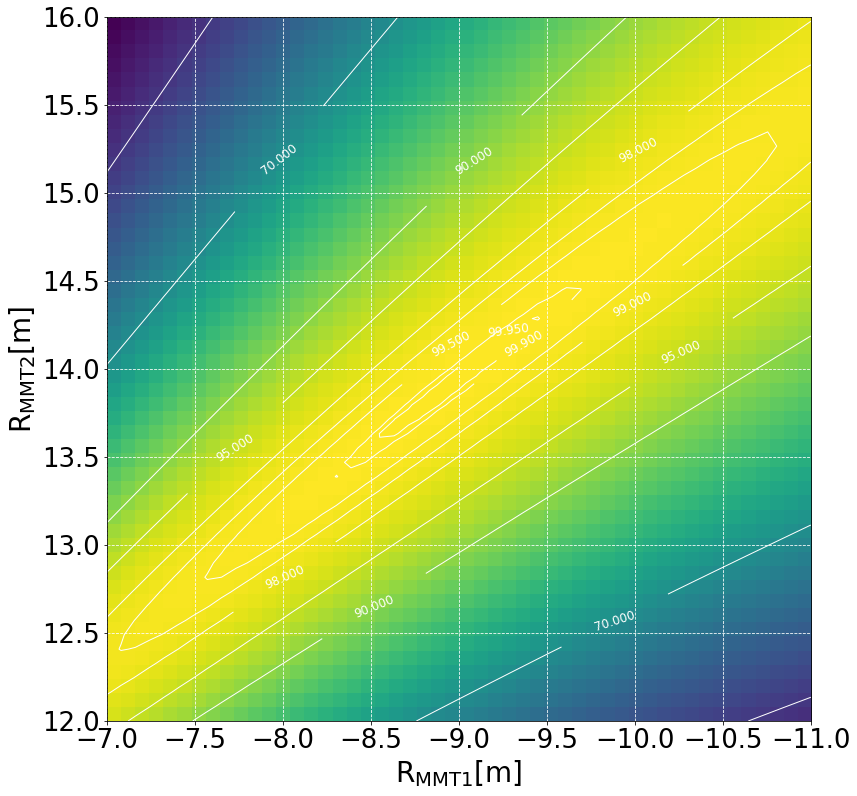

In [213]:

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(MMarray, origin='lower', extent=(R1[0],R1[-1],R2[0],R2[-1]))
#    plt.colorbar(im)
#    levels = [0.5,0.7,0.9,0.95,0.98,0.99,0.995,0.999]
levels = [50,70,90,95,98,99,99.5,99.9,99.95]    
CS = ax.contour(R1,R2, MMarray*100, levels,
                 origin='lower',
                colors='white',
                 linewidths=1)
plt.clabel(CS, fontsize=12, inline=1)

ax.set_xlabel('$\mathsf{R_{MMT1} [m]}$', size=28)
ax.set_ylabel('$\mathsf{R_{MMT2} [m]}$', size=28)
ax.grid(True, color=(1.0,1.0,1.0),ls='--')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(26)

#Figure size and tight fitting
ax.figure.set_size_inches(12,11, forward=True)
plt.tight_layout(pad=0.5)


#### Optimize

In [214]:
def testFunc(x):
    MMT1.inv_ROC_HR = 1.0/x[0]
    MMT2.inv_ROC_HR = 1.0/x[1]
    return -IMMTmodeMatch()**3

x0=[-9,14]
xopt = sopt.fmin_bfgs(testFunc, x0)

MMT1.inv_ROC_HR = 1.0/xopt[0]
MMT2.inv_ROC_HR = 1.0/xopt[1]

#Save optimized values
MMT1_Opt_ROC = xopt[0]
MMT2_Opt_ROC = xopt[1]


Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 9
         Function evaluations: 33
         Gradient evaluations: 11


## Draw ray-tracing results

### Function to propagate IMMT beams

In [215]:
def propagete_MMT_beams():
    beamFromMC = inputBeamDict['beam_MC_trans']
    beams = MMT1.hitFromHR(beamFromMC, order=2)
    inputBeamDict['beam_MC_trans'] = beams['input']
    inputBeamDict['beam_MMT1s1'] = beams['s1']
    inputBeamDict['beam_MMT1t1'] = beams['t1']
    beams['t1'].length = 1.0
    b = beams['r1']

    beams = MMT2.hitFromHR(b, order=2)
    inputBeamDict['beam_MMT1_MMT2'] = beams['input']
    inputBeamDict['beam_MMT2s1'] = beams['s1']
    inputBeamDict['beam_MMT2t1'] = beams['t1']
    beams['t1'].length = 1.0
    b = beams['r1']

    beams = PRM.hitFromAR(b, order=1)
    inputBeamDict['beam_MMT2_PRM'] = beams['input']
    inputBeamDict['beam_PRMs1'] = beams['s1']

### Function to save beams and optics

In [216]:
def save_beams_optics():
    globals()['inputOpticsDictB'] = {'MCi': MCi.copy(), 'MCo': MCo.copy(), 'MCe': MCe.copy(),
                        'MMT1': MMT1.copy(), 'MMT2': MMT2.copy()}

    globals()['inputBeamDictB'] = {}
    for (key, value) in inputBeamDict.items():
        inputBeamDictB[key] = value.copy()


def restore_input_optics():
    for (key, value) in inputOpticsDictB.items():
        globals()[key] = inputOpticsDictB[key] 



### Function to draw the results

In [217]:
def draw_results(dxf_file_name='Layout/bKAGRA_Input.dxf'):
    
    #{{{ Make copies of beams and optics
    #Copies are necessary to avoid the translation of the
    #objects below from intefering with the iLCGT layout 
    #after this section.
    #To copy the items of the dictionary, items() is
    #used. For some reason, copy.deepcopy() did not work
    #correctly

    beamDictCopy = {}
    for (key, value) in beamDict.items():
        beamDictCopy[key] = value.copy()

    auxBeamDictCopy = {}
    for (key, value) in auxBeamDict.items():
        auxBeamDictCopy[key] = value.copy()

    opticsDictCopy = {}
    for (key, value) in opticsDict.items():
        opticsDictCopy[key] = copy.copy(value)

    inputBeamDictCopy = {}
    for (key, value) in inputBeamDict.items():
        inputBeamDictCopy[key] = value.copy()

    inputOpticsCopy = []
    for a in inputOptics:
        inputOpticsCopy.append(a.copy())
    
    #}}}

    #{{{ Translate all objects to put the BS at the center

    transAll(list(beamDictCopy.values()), -BS.HRcenter)
    transAll(list(auxBeamDictCopy.values()), -BS.HRcenter)
    transAll(list(opticsDictCopy.values()), -BS.HRcenter)
    transAll(list(inputBeamDictCopy.values()), -BS.HRcenter)
    transAll(inputOpticsCopy, -BS.HRcenter)


    #}}}

    #{{{ ++ DXF object ++

    tube_offset_dict = {'PRM':(0.0,0.0), 'PR2':(0,-160*mm), 'PR3':(0,160*mm),
                        'SRM':(0.0,0.0), 'SR2':(-160*mm,0), 'SR3':(0,0)}

    d = make_draw_template(opticsDictCopy, tube_offset_dict=tube_offset_dict)

    d.add_layer('input_beam', color=(1.0, 0, 0))
    d.add_layer('input_beam_width', color=(0.6, 0.9, 0))
    d.add_layer('aux_lines', color=(0, 0.9, 0))

    add_input_chambers(d)

    #}}}

    #{{{ ++ Draw Beams ++

    drawAllBeams(d, list(beamDictCopy.values()), drawWidth=True, sigma=2.7, drawPower=False,
                     drawROC=False, drawGouy=False, drawOptDist=False, layer='main_beam',
                        fontSize=0.01)

    drawAllBeams(d, list(auxBeamDictCopy.values()), drawWidth=True, sigma=2.7, drawPower=False,
                 drawROC=False, drawGouy=False, drawOptDist=False, layer='aux_beam',
                 fontSize=0.01)

    drawAllBeams(d, list(inputBeamDictCopy.values()), drawWidth=True, sigma=2.7, drawPower=False,
                     drawROC=False, drawGouy=False, drawOptDist=False, layer='input_beam',
                        fontSize=0.01)

    #}}}

    #{{{ ++ Draw Optics ++

    drawAllOptics(d, list(opticsDictCopy.values()), drawName=True)
    drawAllOptics(d, inputOpticsCopy, drawName=True)

    #}}}

    #{{{ Draw Suspension Footprints

    v1 = np.array([[-110., -110.], [110, -110], [110.0, 110.], [-110, 110], [-110., -110.]])
    c1 = np.array([[-110.+25, -110.], [-110.+25, -110.+25], [-110., -110.+25]])
    c2 = np.array([[110.-25, -110.], [110.-25, -110.+25], [110., -110.+25]])
    c3 = np.array([[110.-25, 110.], [110.-25, 110.-25], [110., 110.-25]])
    c4 = np.array([[-110.+25, 110.], [-110.+25, 110.-25], [-110., 110.-25]])

    v1r = np.array([geom.vector_rotation_2D(v, MMT1.normAngleHR) for v in v1])/1000.+ MMT1.center - BS.HRcenter
    c1r = np.array([geom.vector_rotation_2D(v, MMT1.normAngleHR) for v in c1])/1000.+ MMT1.center - BS.HRcenter
    c2r = np.array([geom.vector_rotation_2D(v, MMT1.normAngleHR) for v in c2])/1000.+ MMT1.center - BS.HRcenter
    c3r = np.array([geom.vector_rotation_2D(v, MMT1.normAngleHR) for v in c3])/1000.+ MMT1.center - BS.HRcenter
    c4r = np.array([geom.vector_rotation_2D(v, MMT1.normAngleHR) for v in c4])/1000.+ MMT1.center - BS.HRcenter

    d.add_shape(draw.PolyLine(x=v1r[:,0], y=v1r[:,1]), layername='Vacuum')
    d.add_shape(draw.PolyLine(x=c1r[:,0], y=c1r[:,1]), layername='Vacuum')
    d.add_shape(draw.PolyLine(x=c2r[:,0], y=c2r[:,1]), layername='Vacuum')
    d.add_shape(draw.PolyLine(x=c3r[:,0], y=c3r[:,1]), layername='Vacuum')
    d.add_shape(draw.PolyLine(x=c4r[:,0], y=c4r[:,1]), layername='Vacuum')

    v1r = np.array([geom.vector_rotation_2D(v, MMT2.normAngleHR) for v in v1])/1000.+ MMT2.center - BS.HRcenter
    c1r = np.array([geom.vector_rotation_2D(v, MMT2.normAngleHR) for v in c1])/1000.+ MMT2.center - BS.HRcenter
    c2r = np.array([geom.vector_rotation_2D(v, MMT2.normAngleHR) for v in c2])/1000.+ MMT2.center - BS.HRcenter
    c3r = np.array([geom.vector_rotation_2D(v, MMT2.normAngleHR) for v in c3])/1000.+ MMT2.center - BS.HRcenter
    c4r = np.array([geom.vector_rotation_2D(v, MMT2.normAngleHR) for v in c4])/1000.+ MMT2.center - BS.HRcenter

    d.add_shape(draw.PolyLine(x=v1r[:,0], y=v1r[:,1]), layername='Vacuum')
    d.add_shape(draw.PolyLine(x=c1r[:,0], y=c1r[:,1]), layername='Vacuum')
    d.add_shape(draw.PolyLine(x=c2r[:,0], y=c2r[:,1]), layername='Vacuum')
    d.add_shape(draw.PolyLine(x=c3r[:,0], y=c3r[:,1]), layername='Vacuum')
    d.add_shape(draw.PolyLine(x=c4r[:,0], y=c4r[:,1]), layername='Vacuum')


    #}}}

    #{{{ Draw helper lines for AR normal 

    v1 = np.array([[0.0, 0.0], [200., 0.0]])
    v1r = np.array([geom.vector_rotation_2D(v, MMT1.normAngleAR) for v in v1])/1000.+ MMT1.ARcenter - BS.HRcenter
    d.add_shape(draw.Line(v1r[0], v1r[1]), layername='aux_lines')
    v1r = np.array([geom.vector_rotation_2D(v, MMT2.normAngleAR) for v in v1])/1000.+ MMT2.ARcenter - BS.HRcenter
    d.add_shape(draw.Line(v1r[0], v1r[1]), layername='aux_lines')

    #}}}

    #{{{ Save DXF file 

    
    renderer.renderDXF(d, dxf_file_name)

    #}}}


### Draw default layout

In [218]:

moveIMMTmirrors(0,0)
propagete_MMT_beams()
draw_results(dxf_file_name='Layout/bKAGRA_Input.dxf')
save_beams_optics()


## Check error tolerance of IMMT

This is an optional section.

### Scan

In [219]:
N = 300
modeMatchArray = np.empty((4,N))
dArray = np.linspace(-15*cm, 15*cm, N)
abs_error = 10*cm
rel_error = 0.0


tic = time.time()
jj=0
for s in (1,-1):
    MMT1.inv_ROC_HR = 1./((1+s*rel_error)*MMT1_Opt_ROC+s*abs_error)
    for t in (1,-1):
        MMT2.inv_ROC_HR = 1./((1+t*rel_error)*MMT2_Opt_ROC+t*abs_error)
        for ii in range(N):
            moveIMMTmirrors(dArray[ii]/2,dArray[ii]/2)
            ans = IMMTmodeMatch()
            modeMatchArray[jj,ii] = ans
        jj=jj+1

toc = time.time()
print('Elapsed time = %f'%(toc - tic))

#Revert to the original value
MMT1.inv_ROC_HR = 1./MMT1_Opt_ROC
MMT2.inv_ROC_HR = 1./MMT2_Opt_ROC


c:\users\yoichi\dropbox\src\git\gtrace\gtrace\optics\geometric.py:193: RuntimeWarning: invalid value encountered in arccos
  if np.arccos(np.dot(v0,v1)) > np.abs(theta):


Elapsed time = 5.531077


### Plot

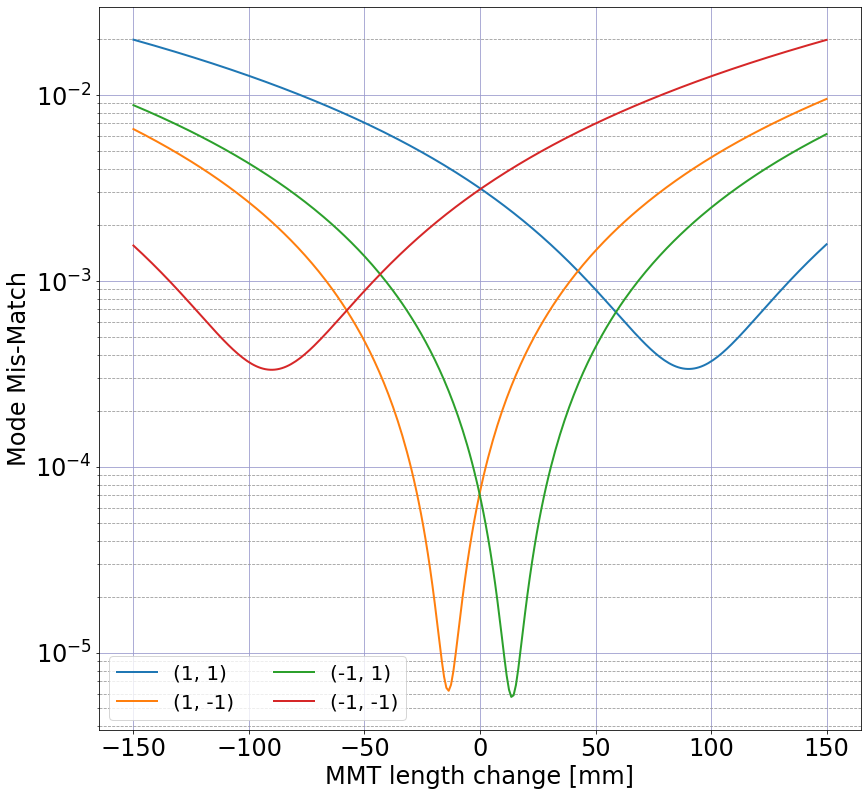

In [220]:
errorList = []
for ii in (1,-1):
    for jj in (1,-1):
        errorList.append((ii,jj))
        
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for ii in range(4):
    ax.semilogy(dArray/mm, 1-modeMatchArray[ii,:], label='(%d, %d)'%(errorList[ii]), lw=2)

ax.grid(True, color=(0.6,0.6,0.8),ls='-')
ax.grid(True, which='minor',color=(0.6,0.6,0.6),ls='--')

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(24)

ax.set_xlabel('MMT length change [mm]', size=24)
ax.set_ylabel('Mode Mis-Match', size=24)

#Legend
h=ax.legend(ncol=2,loc='best', fontsize=20)

#Figure size and tight fitting
ax.figure.set_size_inches(12,11, forward=True)
plt.tight_layout(pad=0.5)


### Mode matching map with ROC errors

In [221]:
#Error
MMT1.inv_ROC_HR = 1./(MMT1_Opt_ROC+50*cm)
MMT2.inv_ROC_HR = 1./(MMT2_Opt_ROC+0*cm)


N = 50
d1 = np.linspace(-150*cm,50*cm,N)
d2 = np.linspace(-50*cm,150*cm,N)
MMarray = np.empty((N,N))
for ii in range(N):
    for  jj in range(N):
        moveIMMTmirrors(d1[ii],d2[jj])
        MMarray[jj,ii] = IMMTmodeMatch()
    
#Revert to the original value
MMT1.inv_ROC_HR = 1./MMT1_Opt_ROC
MMT2.inv_ROC_HR = 1./MMT2_Opt_ROC

### Plot

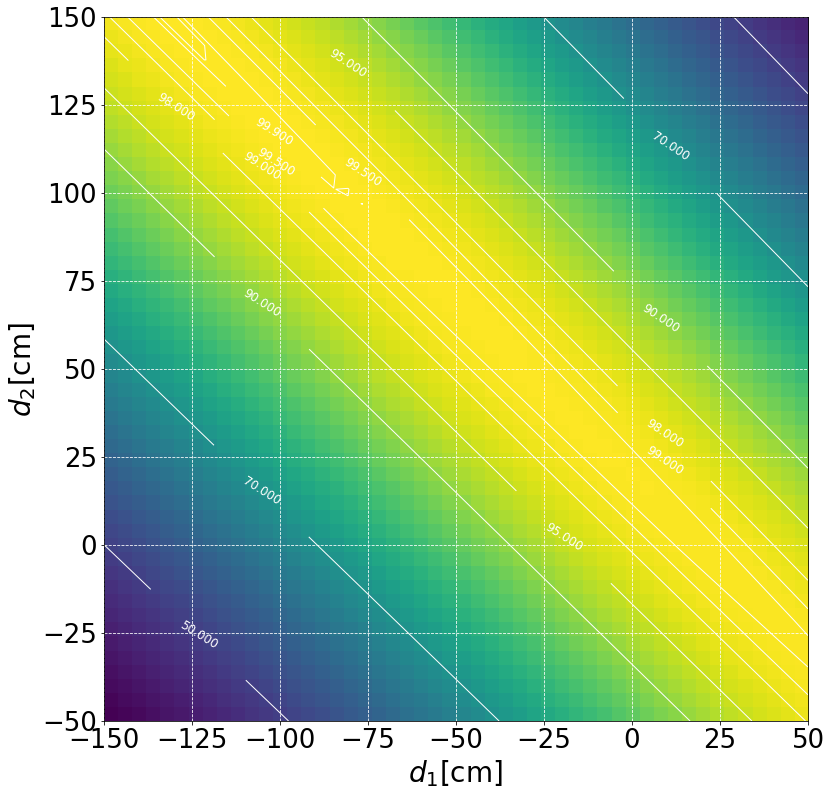

In [222]:

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(MMarray, origin='lower', extent=(d1[0]/cm,d1[-1]/cm,d2[0]/cm,d2[-1]/cm))

# cb=plt.colorbar(im)
# for t in cb.ax.get_yticklabels():
#     t.set_fontsize(18)

#levels = [0.5,0.7,0.9,0.95,0.98,0.99,0.995,0.999,0.9995]
levels = [50,70,90,95,98,99,99.5,99.9,99.95]
CS = ax.contour(d1/cm,d2/cm, MMarray*100, levels,
                 origin='lower',
                colors='white',
                 linewidths=1)
plt.clabel(CS, fontsize=12, inline=1)

ax.set_xlabel('$d_1$[cm]', size=28)
ax.set_ylabel('$d_2$[cm]', size=28)
ax.grid(True, color=(1.0,1.0,1.0),ls='--')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(26)

#Figure size and tight fitting
ax.figure.set_size_inches(12,11, forward=True)
plt.tight_layout(pad=0.5)


### Optimization of the IMMT length for a specific error in ROC

In [223]:
def testFunc(x):
    moveIMMTmirrors(x[0],x[1])
    return -IMMTmodeMatch()**3

#Error
MMT1.inv_ROC_HR = 1./(MMT1_Opt_ROC+10*cm)
MMT2.inv_ROC_HR = 1./(MMT2_Opt_ROC+10*cm)

x0=[5*cm,5*cm]
xopt = sopt.fmin_bfgs(testFunc, x0)

#Revert to the original value
MMT1.inv_ROC_HR = 1./MMT1_Opt_ROC
MMT2.inv_ROC_HR = 1./MMT2_Opt_ROC


Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 6
         Function evaluations: 33
         Gradient evaluations: 11


# Non-sequential trace of the input optics

## Parameters

In [224]:
power_threshold = 1e-3

## From MC input

In [225]:
#Avoid cavity
MCi.term_on_HR = True
MCi.term_on_HR_order = 1

#Input beam
input_beam = inputBeamDict['beam_MC_input']
input_beam.P = 150.0
input_beam.stray_order = 0

beams_MC_input = non_seq_trace(inputOptics+[opticsDict_bKAGRA['PRM']], input_beam, order=30, power_threshold=power_threshold, open_beam_length=2.0)
#beams_MC_input = non_seq_trace(inputOptics, input_beam, order=30, power_threshold=power_threshold)


## From MC output

In [226]:
#Avoid cavity
MCi.term_on_HR = True
MCi.term_on_HR_order = 1
# opticsDict_bKAGRA['PRM'].term_on_HR = True
# opticsDict_bKAGRA['PRM'].term_on_HR_order = 1
# opticsDict_bKAGRA['SRM'].term_on_HR = True
# opticsDict_bKAGRA['SRM'].term_on_HR_order = 1
# opticsDict_bKAGRA['ETMX'].term_on_HR = True
# opticsDict_bKAGRA['ETMY'].term_on_HR = True
# opticsDict_bKAGRA['ETMX'].term_on_HR_order = 2
# opticsDict_bKAGRA['ETMY'].term_on_HR_order = 2

input_beam = inputBeamDict['beam_MC_trans']
input_beam.P = 100.0
input_beam.stray_order = 0

beams_MC_output = non_seq_trace(inputOptics+[opticsDict_bKAGRA['PRM']], input_beam, order=30, power_threshold=power_threshold, open_beam_length=2.0)


## From inside the MC

In [227]:
#Avoid cavity
MCi.term_on_HR = True
MCi.term_on_HR_order = 1

#Input beam
input_beam = inputBeamDict['beam_MCi_MCo'].copy()
input_beam.propagate(0.01)
input_beam.P = 100.0/(1-MCo_Refl)
input_beam.stray_order = 0

beams_MC_inside = non_seq_trace(inputOptics, input_beam, order=30, power_threshold=power_threshold, open_beam_length=2.0)
#beams_MC_input = non_seq_trace(inputOptics, input_beam, order=30, power_threshold=power_threshold)

#Reverse
MCi.term_on_HR = False
MCo.term_on_HR = True
MCo.term_on_HR_order = 1

input_beam.flip()

beams_MC_inside = beams_MC_inside + non_seq_trace(inputOptics, input_beam, order=30, power_threshold=power_threshold, open_beam_length=2.0)


## Draw results

### Make copies of beams and optics

In [228]:
beamListCopy = []
for b in beams_MC_input + beams_MC_output + beams_MC_inside:
    beamListCopy.append(b.copy())

beamDictCopy = {}
for (key, value) in beamDict.items():
    beamDictCopy[key] = value.copy()

auxBeamDictCopy = {}
for (key, value) in auxBeamDict.items():
    auxBeamDictCopy[key] = value.copy()

opticsDictCopy = {}
for (key, value) in opticsDict.items():
    opticsDictCopy[key] = copy.copy(value)

inputBeamDictCopy = {}
for (key, value) in inputBeamDict.items():
    inputBeamDictCopy[key] = value.copy()
    
inputOpticsCopy = []
for a in inputOptics:
    inputOpticsCopy.append(a.copy())
    
#}}}

### Translate all objects to put the BS at the center

In [229]:
transAll(beamListCopy, -opticsDict_bKAGRA['BS'].HRcenter)
transAll(list(beamDictCopy.values()), -BS.HRcenter)
transAll(list(auxBeamDictCopy.values()), -BS.HRcenter)
transAll(list(opticsDictCopy.values()), -BS.HRcenter)
transAll(list(inputBeamDictCopy.values()), -BS.HRcenter)
transAll(inputOpticsCopy, -BS.HRcenter)

### DXF Object

In [230]:
tube_offset_dict = {'PRM':(0.0,0.0), 'PR2':(0,-160*mm), 'PR3':(0,160*mm),
                    'SRM':(0.0,0.0), 'SR2':(-160*mm,0), 'SR3':(0,0)}

d = make_draw_template(opticsDictCopy, tube_offset_dict=tube_offset_dict)

d.add_layer('input_beam', color=(1.0, 0, 0))
d.add_layer('input_beam_width', color=(0.6, 0.9, 0))
d.add_layer("stray_beam", color=(0,255,0))
d.add_layer("stray_beam_width", color=(0,255,255))    

add_input_chambers(d)

### Draw beams

In [231]:
for b in beamListCopy:
    if b.stray_order > 0:
        b.layer = 'stray_beam'
        sigma = 1.0
        drawWidth=True
    else:
        b.layer = 'main_beam'
        sigma = 2.7
        drawWidth=True
    b.draw(d, sigma=sigma, drawWidth=drawWidth, drawPower=True,
           drawName=True, fontSize=1*mm)

drawAllBeams(d, list(inputBeamDictCopy.values()), drawWidth=True, sigma=2.7, drawPower=False,
                 drawROC=False, drawGouy=False, drawOptDist=False, layer='input_beam',
                    fontSize=0.01)

### Draw Optics

In [232]:
drawAllOptics(d, list(opticsDictCopy.values()), drawName=True)
drawAllOptics(d, inputOpticsCopy, drawName=True)

### Save to DXF file

In [233]:
dxf_file_name = 'Layout/bKAGRA_Input_stray.dxf'
renderer.renderDXF(d, dxf_file_name)


# Exporting mirror coordinates

Here, positions and orientations of all the mirrors are exported to a text file.

## Make copies of beams and optics

In [234]:
opticsDictCopyB = {}
for (key, value) in opticsDict_bKAGRA.items():
    opticsDictCopyB[key] = copy.copy(value)
for (key, value) in inputOpticsDictB.items():
    opticsDictCopyB[key] = copy.copy(value)

## Translate all objects to put the BS at the cente

In [235]:

transAll(list(opticsDictCopyB.values()), -opticsDict_bKAGRA['BS'].HRcenter)

## Print all optics coordinates

In [236]:

OutputText = 'Optics Name: HR Center, HR Chord Center, Center of Mass, Normal Vector, Normal Angle [deg]\n'

for (Name, M) in opticsDictCopyB.items():
    OutputText = OutputText + Name + ': '+str(M.HRcenter)+' , '+str(M.HRcenterC)+' , '+str(M.center)+','+str(M.normVectHR)+','+str(rad2deg(M.normAngleHR))+'\n'

print(OutputText)



Optics Name: HR Center, HR Chord Center, Center of Mass, Normal Vector, Normal Angle [deg]
PRM: [-19.46210745   0.22671689] , [-19.4620904    0.22671694] , [-19.5120902   0.226575 ],[0.99999597 0.00283876],0.16264931197018656
PR2: [-4.70067857  0.26862124] , [-4.69813825  0.26865428] , [-4.64814248  0.26930455],[-0.99991543 -0.01300532],180.74517075906883
PR3: [-1.57637713e+01  1.22147218e-02] , [-1.57634577e+01  1.22182331e-02] , [-1.58134546e+01  1.16583013e-02],[0.99993729 0.01119864],0.6416479927957189
BS: [-2.33146835e-15  3.81639165e-17] , [-2.33146835e-15  3.81639165e-17] , [ 0.02827797 -0.02829058],[-0.70694913  0.7072644 ],134.98722689115667
ITMX: [ 2.65071128e+01 -1.63807285e-02] , [ 2.65071160e+01 -1.63807285e-02] , [ 2.64321160e+01 -1.63807285e-02],[1. 0.],0.0
ITMY: [-7.59055707e-03  2.32219757e+01] , [-7.59055707e-03  2.32219789e+01] , [-7.59055707e-03  2.31469789e+01],[6.123234e-17 1.000000e+00],90.0
SR3: [  0.04723878 -15.69395074] , [  0.04724209 -15.69363721] , [  0.04

## Print beam incident points on AR surfaces

In [237]:

OutputText += '\n---------------- AR ------------------\n\n'

#MCi AR
ARC = inputBeamDictB['beam_MCi_s1'].pos - opticsDict_bKAGRA['BS'].HRcenter
OutputText += 'MCi AR incident pont: '+str(ARC)+'\n'

#MCo AR
ARC = inputBeamDictB['beam_MC_trans'].pos - opticsDict_bKAGRA['BS'].HRcenter
OutputText += 'MCo AR output pont: '+str(ARC)+'\n'

#PRM AR
ARC = inputBeamDictB['beam_PRMs1'].pos - opticsDict_bKAGRA['BS'].HRcenter
OutputText += 'PRM AR incident pont: '+str(ARC)+'\n'

#BS AR X
ARC = beamDict_bKAGRA['beamBStoITMX'].pos - opticsDict_bKAGRA['BS'].HRcenter
OutputText += 'BS AR to X arm: '+str(ARC)+'\n'

#BS AR SRC
ARC = beamDict_bKAGRA['beamBStoSR3X'].pos - opticsDict_bKAGRA['BS'].HRcenter
OutputText += 'BS AR to SRC: '+str(ARC)+'\n'

#ITMX AR
ARC = beamDict_bKAGRA['beamITMXs1'].pos - opticsDict_bKAGRA['BS'].HRcenter
OutputText += 'ITMX AR incident point: '+str(ARC)+'\n'

#ITMY AR
ARC = beamDict_bKAGRA['beamITMYs1'].pos - opticsDict_bKAGRA['BS'].HRcenter
OutputText += 'ITMY AR incident point: '+str(ARC)+'\n'

#SRM AR
ARC = beamDict_bKAGRA['beamSRMt1X'].pos - opticsDict_bKAGRA['BS'].HRcenter
OutputText += 'SRM AR output point: '+str(ARC)+'\n'

#ETMX
ARC = beamDict_bKAGRA['beamETMXtrans'].pos - opticsDict_bKAGRA['BS'].HRcenter
OutputText += 'ETMX AR output point: '+str(ARC)+'\n'
(x,y)=beamDict_bKAGRA['beamETMXtrans'].dirVect
OutputText += 'ETMX transmission beam direction vector = ({0:.6}, {1:.6})\n'.format(x,y)

#ETMY
ARC = beamDict_bKAGRA['beamETMYtrans'].pos - opticsDict_bKAGRA['BS'].HRcenter
OutputText += 'ETMY AR output point: '+str(ARC)+'\n'
(x,y)=beamDict_bKAGRA['beamETMYtrans'].dirVect
OutputText += 'ETMY transmission beam direction vector = ({0:.6}, {1:.6})\n'.format(x,y)

## Save to a file

In [238]:
file_name = 'Layout/bKAGRA_Mirror_Coordinates.txt'
logfile = open(file_name, 'w')
logfile.write(OutputText)
logfile.close()